In [1]:
import funciones_eventos as ev

import pandas as pd
#import geopandas as gpd

import pickle as pk

import networkx as nx


import numpy as np
#from sklearn.cluster import KMeans

from itertools import permutations,combinations,accumulate

#import matplotlib
#mpl.rcParams.update(mpl.rcParamsDefault)
import matplotlib
from matplotlib.ticker import FormatStrFormatter

# from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

import matplotlib.pyplot as plt 
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg
import matplotlib.cm as cm
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.lines as mlines
import matplotlib.patches as mpatches

#from unidecode import unidecode

from scipy import stats

plt.style.use('seaborn-v0_8-white')

In [2]:
topics=20
topics_labels=['T{}'.format(i) for i in range(topics)]

path_agenda=r'...\Agendas\\'.format(topics)


#provincias to work with:
provincias2analyze= ['Buenos Aires', 'Cordoba','Tucuman','Mendoza','Santa Fe','Santiago del estero']
provincias2analyze_labels=['Buenos Aires', 'Córdoba','Tucumán','Mendoza','Santa Fe','Santiago del Estero']

provincias_labels={k:v for k,v in zip(provincias2analyze,provincias2analyze_labels)}


topics_names=['Alberto_Fernandez','Avion_Irani','Cambiemos','Combustible','Corte_Suprema',
                 'Cristina_Kirchner','Cumbre_EEUU','Diego_Luciani','Dolar','Gasoducto','Inflacion',
                 'Javier_Milei','Juan_Manzur','Milagro_Sala','Paro','Planes_Sociales','Sabag_Montiel',
                'Sergio_Massa','Silvina_Batakis','Subsidio_Energia']

topics_final_names=['Government','Diplomatic conflict','Opposition','Fuel Shortage','Supreme Court','Vice President',
               'International affairs','Vice President Trials','Dollar','Gas Pipeline','Inflation','Libertarian Party',
               'Domestic politics','Social Leader','Strikes','Social Assistance','Assault on Vice President',
               'Economy Minister','Former Economy Minister','Subsidy Segmentation']

topics_labels={k:v for k,v in zip(topics_names,topics_final_names)}

    
dfs=[]
for interest_top in topics_names:
    #Series continuas
    n='topic_series_{}.txt'.format(interest_top)
    dfcont=pd.read_csv(path_agendas_prov+n)
    dfs.append(dfcont)
    
    
#Matrices Giulio
dict_g = pk.load(open(r'...\all_metrics_and_p_values.pkl', 'rb'))
# indices superiores
iu1 = np.triu_indices(len(provincias2analyze), 1)
indxi=iu1[0]
indxj=iu1[1]
pval_ref_pte=0.05
pval_ref_mi=0.01
Lag=3
#coloresdefault=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2','#7f7f7f', '#bcbd22', '#17becf']

#estilo
L_prov=len(provincias2analyze)

fontsize_big=30 #titulos
fontsize_normal=25 #labels
fontsize_small=20 #ticks
fontsize_xsmall=18
fontsize_xxsmall=15

In [3]:
new_etiquetas_tops_trad=['Government','Vice President Trials','Opposition','Assault on Vice President',
    'Diplomatic conflict','Inflation','Dollar','Economy Minister','Former Economy Minister','Social Assistance',
    'Supreme Court','International affairs','Gas Pipeline','Libertarian Party','Social Leader','Fuel Shortage',
    'Subsidy Segmentation','Strikes','Vice President','Domestic politics']

titulos_test=['Sabag_Montiel', 'Cristina_Kirchner', 'Avion_Irani', 'Silvina_Batakis', 'Sergio_Massa', 'Gasoducto', 
              'Milagro_Sala', 'Juan_Manzur', 'Diego_Luciani', 'Dolar', 'Corte_Suprema', 'Alberto_Fernandez', 'Inflacion', 
              'Paro', 'Combustible', 'Javier_Milei', 'Subsidio_Energia', 'Cambiemos', 'Cumbre_EEUU', 'Planes_Sociales']

dict_titulos={k:v for k,v in zip(titulos_test,range(1,topics+1))}


{'Sabag_Montiel': 1, 'Cristina_Kirchner': 2, 'Avion_Irani': 3, 'Silvina_Batakis': 4, 'Sergio_Massa': 5, 'Gasoducto': 6, 'Milagro_Sala': 7, 'Juan_Manzur': 8, 'Diego_Luciani': 9, 'Dolar': 10, 'Corte_Suprema': 11, 'Alberto_Fernandez': 12, 'Inflacion': 13, 'Paro': 14, 'Combustible': 15, 'Javier_Milei': 16, 'Subsidio_Energia': 17, 'Cambiemos': 18, 'Cumbre_EEUU': 19, 'Planes_Sociales': 20}


In [4]:
methods=['MI', 'pTE', 'TE', 'GC']

method_matrices={}
for met in methods:
    sub={}
    for top2 in topics_names:  
        M_val=np.zeros((6,6))
        M_pval=np.zeros((6,6))
        for s,t in permutations(range(len(provincias2analyze)), 2):
            p_s=provincias2analyze[s] #col-source
            p_t=provincias2analyze[t] #fila-target
            
            val=dict_g[met][('_'+top2,p_s,p_t)][0]
            pval=dict_g[met][('_'+top2,p_s,p_t)][1]

            M_val[s,t]=val
            M_pval[s,t]=pval
        sub[top]=(M_val,M_pval)
    method_matrices[met]=sub
    
dist_topicos={}
matrices_topicos={}
for t,interest_top in enumerate(topics_names):

    #dfsel=dfs[topicos_orden_final.index(interest_top)]
    dfsel=dfs[t]
    
    n='topic_series_{}.txt'.format(interest_top)
    dfcont=pd.read_csv(path_agendas_prov+n)
    series=[]
    for prov in provincias2analyze:
        serie_prov=dfcont[prov].to_numpy()          
        series.extend(serie_prov)            
    distsel=series
    dist_topicos[interest_top]=distsel

    #defino los t1
    th0=np.mean(distsel)
    th1=th0+np.std(distsel)
    #normalizo
    #th1=np.round(th1,3)
    
    umbrales=(th0,th1)
    print('Th0: ',th0,'Th1: ',th1)

    #print(interest_top,umbrales)
    #Cristina
    matrices_c_umbrales={}

    QS_c=np.zeros((len(provincias2analyze),len(provincias2analyze)))
    QA_c=np.zeros((len(provincias2analyze),len(provincias2analyze)))
    C_c=np.zeros((len(provincias2analyze),len(provincias2analyze)))    
    Mnoe_c=np.zeros((len(provincias2analyze),len(provincias2analyze)))    
    
    for i,p1 in enumerate(provincias2analyze):
        #eventos
        c1=ev.event_transform_cristina(dfsel[p1],th1,th0)
        noe_c1=np.nonzero(c1)[0].shape[0]
        for j,p2 in enumerate(provincias2analyze):
            c2=ev.event_transform_cristina(dfsel[p2],th1,th0)        
            noe_c2=np.nonzero(c2)[0].shape[0]
            _,c_a=ev.func_c(c1,c2,lag=Lag)
            _,c_b=ev.func_c(c2,c1,lag=Lag)
            eventos_totales=(noe_c1+noe_c2)
            if eventos_totales != 0:
                s= (c_b+ c_a)/eventos_totales
                a= (c_b - c_a)/eventos_totales
            else:
                s=0
                a=0
            QS_c[i,j]=s
            QA_c[i,j]=a
            C_c[i,j]=c_a
            Mnoe_c[j,i]=eventos_totales
            
    QS_c=2*QS_c
    QA_c=2*QA_c
    C_c=2*C_c
    np.fill_diagonal(QS_c,0)
    np.fill_diagonal(QA_c,0)
    np.fill_diagonal(C_c,0)
    np.fill_diagonal(Mnoe_c,1)
    
    matrices_topicos[interest_top]=([QS_c,QA_c,C_c,Mnoe_c],umbrales)

Th0:  0.044710630688901125 Th1:  0.07676225073206366
Alberto_Fernandez
QA:  0.5714285714285714 QS:  1.0666666666666667
Th0:  0.03459294849878763 Th1:  0.0885658606817447
Avion_Irani
QA:  1.0 QS:  1.0
Th0:  0.07057664412140602 Th1:  0.1144043985857116
Cambiemos
QA:  0.6666666666666666 QS:  0.8571428571428571
Th0:  0.030346635463887394 Th1:  0.06323108655580426
Combustible
QA:  0.35294117647058826 QS:  0.875
Th0:  0.08130547255213989 Th1:  0.13449553557215135
Corte_Suprema
QA:  0.5714285714285714 QS:  1.3333333333333333
Th0:  0.07563765000648713 Th1:  0.157589139411387
Cristina_Kirchner
QA:  0.6666666666666666 QS:  1.0
Th0:  0.05579045386164077 Th1:  0.09809797971005078
Cumbre_EEUU
QA:  0.5 QS:  1.0
Th0:  0.05101892953286985 Th1:  0.11105068289046649
Diego_Luciani
QA:  0.5454545454545454 QS:  1.0909090909090908
Th0:  0.03557886739342242 Th1:  0.07197213558790036
Dolar
QA:  0.6666666666666666 QS:  1.0
Th0:  0.03043286039549698 Th1:  0.06957731465904393
Gasoducto
QA:  0.6666666666666666 QS

## Fig 1: Agenda

In [6]:
agenda_global=pd.read_csv(path_agenda+'series_agenda.csv')

dfgraf=agenda_global.copy()
dates = list(dfgraf['fecha'])
fechasx=[ '{}-{}'.format(x.split('-')[2],x.split('-')[1],x.split('-')[0]) for x in dates]
x_range = list(range(len(fechasx)))

#cambio nombre cols
dfgraf.columns=['fecha']+new_etiquetas_tops_trad

dfgraf=dfgraf[dfgraf.columns[1:]]

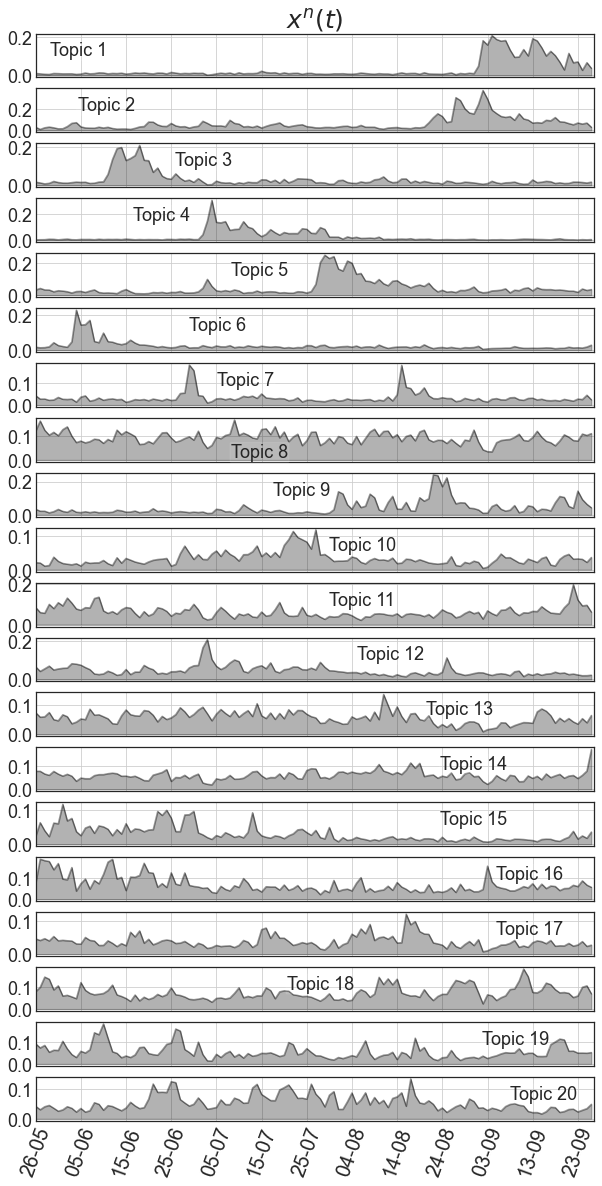

In [301]:
fig, axs = plt.subplots(topics, 1, figsize=(10, 20), sharex=True)
inter=10

axs=axs.flatten()
ysticks=[]
ysticks_labels=[]
for ax,i,int_top in zip(axs,range(topics),titulos_test):
    int_top=topics_labels[int_top]
    
    y=dfgraf[int_top].to_numpy()
    x=range(len(y))
    
    ax.plot(x,y,color='k',alpha=0.4)
    ax.fill_between(x, y,0,color='k', alpha=0.3)
    ax.tick_params(axis='y', which='major', labelsize=fontsize_xsmall)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

 
    # Agregar textos al segundo subgráfico
    txt='Topic {}'.format(str(i+1))
    if i == 2:
        text_xpos=(i+3)/topics
        text_ypos=0.5
    elif i == 4:
        text_xpos=(i+3)/topics
        text_ypos=0.5
    elif i == 7:
        text_xpos=(i)/topics
        text_ypos=0.1
    elif i == 9:
        text_xpos=(i+1.5)/topics
        text_ypos=0.5
    elif i == 12:
        text_xpos=(i+2)/topics
        text_ypos=0.5
    elif i == 13:
        text_xpos=(i+1.5)/topics
        text_ypos=0.5
    elif i == 15:
        text_xpos=(i+1.5)/topics
        text_ypos=0.5
    elif i == 17:
        text_xpos=(9)/topics
        text_ypos=0.5
    elif i == 18:
        text_xpos=(i-2)/topics
        text_ypos=0.5
    elif i == 19:
        text_xpos=(i-2)/topics
        text_ypos=0.5
        
    else:
        text_xpos=(i+0.5)/topics
        text_ypos=0.5
    ax.text(text_xpos,text_ypos, txt, fontsize=fontsize_xsmall, ha='left', transform=ax.transAxes,
                bbox=dict(facecolor='white', edgecolor='white', boxstyle='round,pad=0.05',alpha=0.1))

    ax.grid()

axs[0].set_title('$x^{n}(t)$',fontsize=25)
ax.set_xlim([0.5,len(x_range)-0.5])
ax.set_xticks(np.arange(0, len(x_range),inter))
ax.set_xticklabels(fechasx[::inter],rotation=70,fontsize=fontsize_small)

fig.subplots_adjust(hspace=0.25)
plt.show()

## Fig 2:

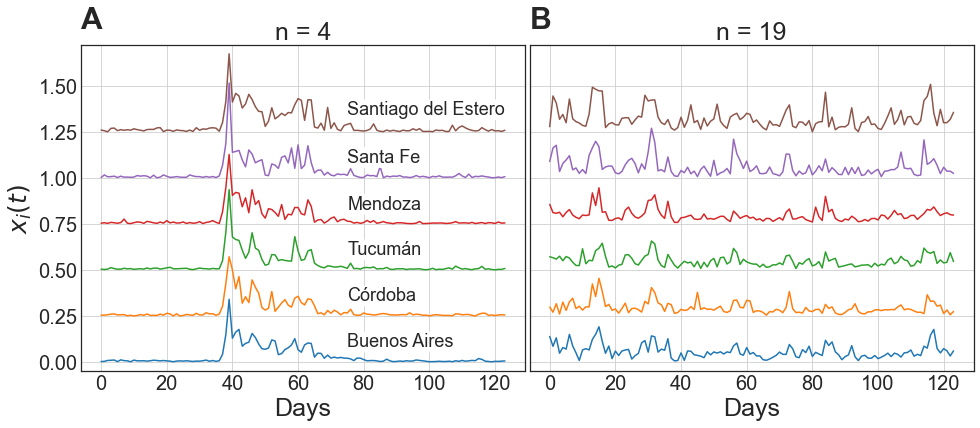

In [179]:
agenda_global=pd.read_csv(path_agenda+'series_agenda.csv')

dfgraf=agenda_global.copy()
dates = list(dfgraf['fecha'])
fechasx=[ '{}-{}'.format(x.split('-')[2],x.split('-')[1],x.split('-')[0]) for x in dates]
x_range = list(range(len(fechasx)))

#cambio nombre cols
dfgraf.columns=['fecha']+new_etiquetas_tops_trad
dfplot=dfgraf[dfgraf.columns[1:]]

fig, axs = plt.subplots(1,2,figsize=(16,6),sharey=True)
ax1,ax2=axs
int_top1='Silvina_Batakis'
int_top2='Cumbre_EEUU'


inter=10

top_ind1=topics_names.index(int_top1)
dfsel=dfs[top_ind1]
yticks_ax1=[]
ysticks=[]
for i,p1 in enumerate(provincias2analyze):
    serie=dfsel[p1]
    y=serie+(i*0.25)
    yticks_ax1.append(np.mean(y))
    ax1.plot(y,label=p1)
    
ax1.grid(True)
ax1.set_title('n = {}'.format(dict_titulos[int_top1]),fontsize=fontsize_normal)
ax1.tick_params(axis='y', which='major', labelsize=fontsize_small)
ax1.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax1.set_ylim([-0.05,1.72])
ax1.set_xlabel('Days',fontsize=25)


top_ind2=topics_names.index(int_top2)
dfsel=dfs[top_ind2]
for i,p1 in enumerate(provincias2analyze):
    serie=dfsel[p1]
    y=serie+(i*0.25)
    ax2.plot(y,label=p1)
    

ax2.set_title('n = {}'.format(dict_titulos[int_top2]),fontsize=fontsize_normal)
ax2.grid(True)
ax2.set_xlabel('Days',fontsize=25)
ax1.set_ylabel('$x_{i}(t)$',fontsize=25)
ax1.tick_params(axis='x', which='major', labelsize=fontsize_small)
ax2.tick_params(axis='x', which='major', labelsize=fontsize_small)

ax1.text(x=0, y=1.05, s="A", fontsize=fontsize_big,fontweight='bold', transform=ax1.transAxes)
ax2.text(x=0, y=1.05, s="B", fontsize=fontsize_big,fontweight='bold', transform=ax2.transAxes)

# Agregar textos al segundo subgráfico
for y_pos,txt in zip(yticks_ax1,provincias2analyze_labels):
    ax1.text(75, y_pos+0.05, txt, fontsize=fontsize_xsmall, ha='left',
            bbox=dict(facecolor='white', edgecolor='white', boxstyle='round,pad=0.05'))

plt.subplots_adjust(wspace=0.01)
plt.show()

## Fig3:

x_2(t)


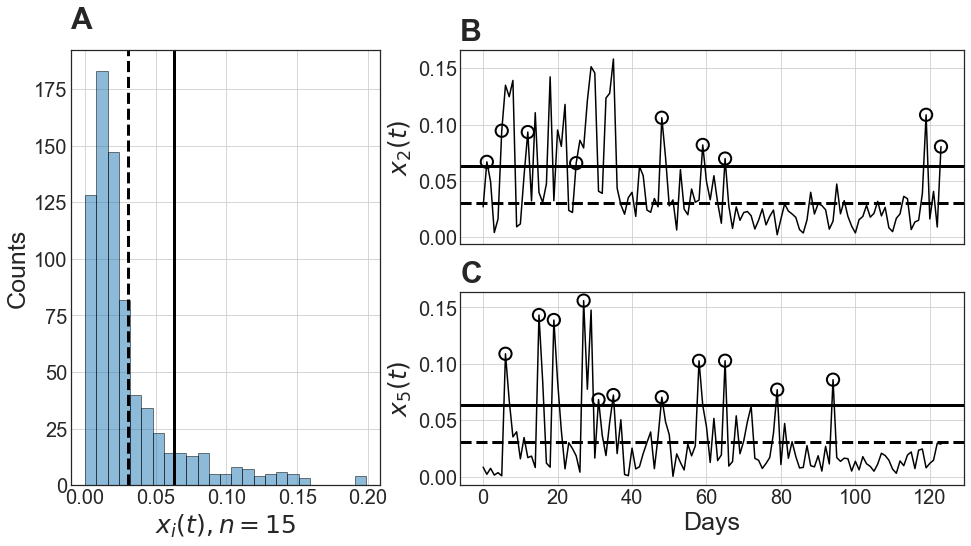

In [161]:
int_top='Combustible'
dfsel=dfs[topics_names.index(int_top)]
_,umbrales=matrices_topicos[int_top]
th0,th1=umbrales

dist_k=dist_topicos[int_top]

j1,j2 ='Cordoba','Santa Fe'


fig = plt.figure(figsize=(16, 8))
gs = fig.add_gridspec(2, 5)
#primero agrego las series de eventos
ax0 = fig.add_subplot(gs[0,2:5])#,sharex=ax0)
ax1 = fig.add_subplot(gs[1,2:5])
#histograma
ax = fig.add_subplot(gs[:,0:2])


ax.hist(dist_k,bins=25,alpha=0.5,edgecolor='black')

ax.grid()
ax.tick_params(axis='both', which='major', labelsize=fontsize_small)
N=dict_titulos[int_top]

ax.set_ylabel('Counts',fontsize=fontsize_normal)


#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
y1=dfsel[j1].copy()
y2=dfsel[j2].copy()


x1=range(len(dfsel[j1]))
p1,=ax0.plot(y1,color='k',label=j1)
p2,=ax1.plot(y2,color='k',label=j2)


ev_array1=ev.event_transform_cristina(y1,th1,th0) #serie binaria de eventos
indev1=np.nonzero(ev_array1) #posiciones de eventos
noe_c1=indev1[0].shape[0] #cantidad de eventos

ev_array2=ev.event_transform_cristina(y2,th1,th0)
indev2=np.nonzero(ev_array2)
noe_c2=indev2[0].shape[0]

y_eventos1=dfsel[j1].to_numpy()[indev1] #posiciones en el eje y de los eventos
ax0.scatter(indev1,y_eventos1,s=150,facecolors='none', edgecolors='k',linewidth=2,zorder=3)

y_eventos2=dfsel[j2].to_numpy()[indev2]
ax1.scatter(indev2,y_eventos2,s=150,facecolors='none', edgecolors='k',linewidth=2,zorder=3)

ax0.axhline(th1,c='k',ls='-',lw=3)
ax0.axhline(th0,c='k',ls='--',lw=3)
ax1.axhline(th1,c='k',ls='-',lw=3)
ax1.axhline(th0,c='k',ls='--',lw=3)
ax.axvline(th1,c='k',ls='-',label='$\mu + \sigma$',lw=3)
ax.axvline(th0,c='k',ls='--',label='$\mu$',lw=3)


ax0.grid(True)
ax1.grid(True)


int_j1=provincias2analyze.index(j1)+1
int_j2=provincias2analyze.index(j2)+1
st1='x_{}'.format(int_j1)+'(t)'#, N=15'#'(t,15)'
ax0.set_ylabel(r'${}$'.format(st1),fontsize=fontsize_normal)
st2='x_{}'.format(int_j2)+'(t)'#, N=15'#'(t,15)'
ax1.set_ylabel(r'${}$'.format(st2),fontsize=fontsize_normal)


st=r'x_{i}(t), n=15'
ax.set_xlabel(r'${}$'.format(st),fontsize=fontsize_normal)

ax1.set_xlabel('Days',fontsize=25)
ax0.set_xticklabels([])
ax0.tick_params(axis='y', which='major', labelsize=fontsize_small)
ax1.tick_params(axis='both', which='major', labelsize=fontsize_small)

ax.text(x=0, y=1.05, s="A", fontsize=fontsize_big,fontweight='bold', transform=ax.transAxes)
ax0.text(x=0, y=1.05, s="B", fontsize=fontsize_big,fontweight='bold', transform=ax0.transAxes)
ax1.text(x=0, y=1.05, s="C", fontsize=fontsize_big,fontweight='bold', transform=ax1.transAxes)

plt.subplots_adjust(wspace=0.7,hspace=0.25)
plt.show()

## Fig 4:

In [10]:
M=np.zeros((len(provincias2analyze),topics))
for j,int_top in zip(range(topics),titulos_test): 
    dist_k=dist_topicos[int_top]
    th0=np.mean(dist_k)
    th1=np.mean(dist_k)+np.std(dist_k)

    for i,prov in zip(range(topics),provincias2analyze):
        dfsel=dfs[topics_names.index(int_top)]
        y=dfsel[prov].copy()        
        ev_array=ev.event_transform_cristina(y,th1,th0)
        c=np.nonzero(ev_array)[0].shape[0]
        M[i,j]=c
        
# Calcular el valor medio de cada columna
valores_medios = np.mean(M, axis=0)
# Obtener los índices que ordenarían los valores medios de menor a mayor
indices_ordenados = np.argsort(valores_medios)
valores_medios_ordenados=[valores_medios[x] for x in indices_ordenados]
# Ordenar las columnas de la matriz según los índices obtenidos
matriz_ordenada = M[:, indices_ordenados]

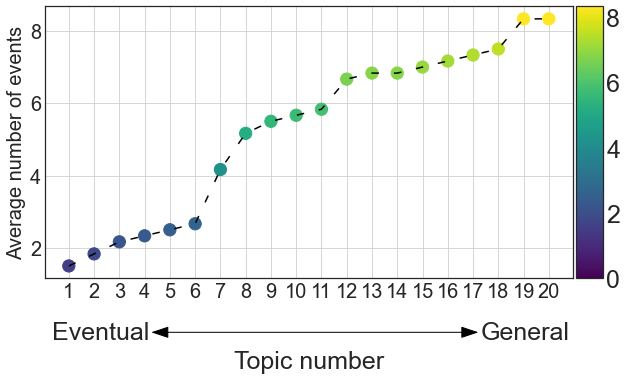

In [12]:
xticks_ords=[topics_labels[topics_names[x]] for x in indices_ordenados]

# Configurar el subplot
fig, ax0 = plt.subplots(1, 1, figsize=(10, 5))#,sharex=True)

# Subplot 0: Mostrar el valor medio de las columnas
scat=ax0.scatter(range(topics), valores_medios_ordenados,marker='o',s=150,c=valores_medios_ordenados,
                 cmap=cm.viridis,vmin=0,vmax=max(valores_medios_ordenados))
ax0.plot(range(topics), valores_medios_ordenados,linestyle='--', dashes=(5, 10),color='k')
# Añadir una barra de colores
divider = make_axes_locatable(ax0)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(scat, cax=cax)
cax.tick_params(labelsize=fontsize_normal)

ax0.grid()
ax0.set_xticks(range(topics),range(1,topics+1),rotation=0,fontsize=fontsize_small)
ax0.tick_params(axis='y', which='major', labelsize=fontsize_small)
ax0.set_ylabel('Average number of events',fontsize=fontsize_small)
ax0.set_xlabel('Topic number',fontsize=fontsize_normal)
ax0.xaxis.labelpad = 50


# Coordenadas del inicio y fin de las flechas
x_start = 0.3
x_end = 0.7
y = 0.0
yoffset=-0.025
xoffset=0.03
# Crear las flechas
arrow = FancyArrowPatch((x_start-xoffset, y+yoffset), (x_end+xoffset, y+yoffset),transform=fig.transFigure, mutation_scale=5, 
                arrowstyle='<|-|>,head_width=1,head_length=3',
                             color='black')

# Agregar las flechas al gráfico
fig.patches.append(arrow)
ax0.text(x_start-xoffset, y+yoffset, 'Eventual', ha='right', va='center', fontsize=fontsize_normal,transform=fig.transFigure)
ax0.text(x_end+xoffset, y+yoffset, 'General', ha='left', va='center', fontsize=fontsize_normal,transform=fig.transFigure)

# Ajustar el diseño y mostrar el gráfico
plt.subplots_adjust(hspace=0.5)
plt.show()

## Fig 5:

2.0 4.0 20


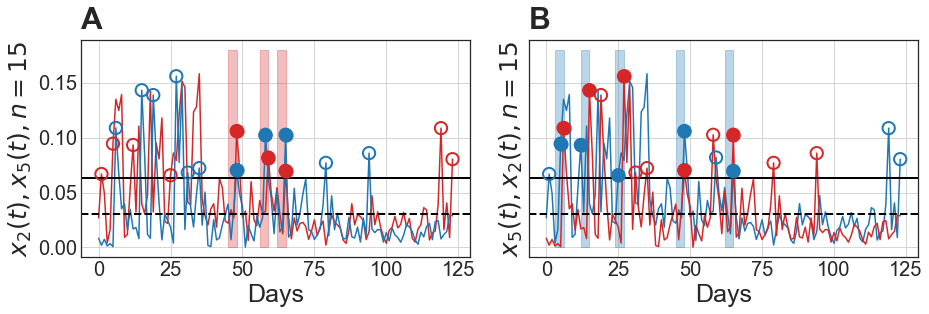

In [13]:
int_top='Combustible'

dfsel=dfs[topics_names.index(int_top)]
_,umbrales=matrices_topicos[int_top]
th0,th1=umbrales

dist_k=dist_topicos[int_top]

j1,j2 ='Cordoba','Santa Fe'#'Santa Fe'#'Cordoba'

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)


fig, axs = plt.subplots(1,2,figsize=(15,4),sharey=True)
ax0=axs[0]
ax1=axs[1]

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
y1=dfsel[j1].copy()
y2=dfsel[j2].copy()


x1=range(len(dfsel[j1]))
p1,=ax0.plot(y1,color='tab:red',label=j1)
p2,=ax0.plot(y2,color='tab:blue',label=j2)

p1,=ax1.plot(y1,color='tab:blue',label=j1)
p2,=ax1.plot(y2,color='tab:red',label=j2)

ev_array1=ev.event_transform_cristina(y1,th1,th0)
indev1=np.nonzero(ev_array1)
noe_c1=indev1[0].shape[0]

eventos1=dfsel[j1].to_numpy()[indev1]
ax0.scatter(indev1,eventos1,s=150,facecolors='none', edgecolors='tab:red',linewidth=2,zorder=3)
ax1.scatter(indev1,eventos1,s=150,facecolors='none', edgecolors='tab:blue',linewidth=2,zorder=3)


ev_array2=ev.event_transform_cristina(y2,th1,th0)
indev2=np.nonzero(ev_array2)
noe_c2=indev2[0].shape[0]

eventos2=dfsel[j2].to_numpy()[indev2]
ax0.scatter(indev2,eventos2,s=150,facecolors='none', edgecolors='tab:blue',linewidth=2,zorder=3)
ax1.scatter(indev2,eventos2,s=150,facecolors='none', edgecolors='tab:red',linewidth=2,zorder=3)


indx_a,c_a=ev.func_c(ev_array1,ev_array2,lag=Lag)
indx_b,c_b=ev.func_c(ev_array2,ev_array1,lag=Lag)


coincidencias_az=[]
for ev_az in indev2[0]:
    for ev_r in indev1[0]:
        dif= ev_az - ev_r
        if 0<= dif <= Lag:
            #si appendeo ev_az veo los eventos azules sobre rojo
            #si appendeo ev_r veo los eventos en rojo que ven los azules
            coincidencias_az.append(ev_r)
        else:
            coincidencias_az.append('nan')
coincidencias_az=np.asarray(coincidencias_az)
coin_az=coincidencias_az[coincidencias_az.astype(str)  != 'nan']
indx2paint_az=[int(x) for x in coin_az]

evb=dfsel[j1].to_numpy()[indx2paint_az]
ax1.scatter(indx2paint_az,evb,s=150, color='tab:blue',linewidth=2,zorder=3)

coincidencias_r=[]
for ev_r in indev1[0]:
    for ev_az in indev2[0]:
        dif= ev_r - ev_az
        if 0<= dif <= Lag:
            coincidencias_r.append(ev_az)
        else:
            coincidencias_r.append('nan')

coincidencias_r=np.asarray(coincidencias_r)
coin_r=coincidencias_r[coincidencias_r.astype(str) != 'nan']
indx2paint_r=[int(x) for x in coin_r]
evb=dfsel[j2].to_numpy()[indx2paint_r]
ax0.scatter(indx2paint_r,evb,s=150, color='tab:blue',linewidth=2,zorder=3)        


eva=dfsel[j2].to_numpy()[indx_a]
ax1.scatter(indx_a,eva,s=150, color='tab:red',linewidth=2,zorder=3)

evb=dfsel[j1].to_numpy()[indx_b]
ax0.scatter(indx_b,evb,s=150, color='tab:red',linewidth=2,zorder=3)


# Obtener los ticks actuales en el eje Y
yticks = plt.yticks()[0]
# Encontrar el valor máximo de los ticks en el eje Y
ys=np.linspace(0,max(yticks))
# Pintar la zona de rojo con transparencia desde el índice dado

for ix in indx_a:
    ax1.fill_betweenx(ys, ix-Lag, ix, color='tab:blue', alpha=0.3)
for ix in indx_b:
    ax0.fill_betweenx(ys, ix-Lag, ix, color='tab:red', alpha=0.3)


eventos_totales=(noe_c1+noe_c2)
if eventos_totales != 0:
    s= 2*(c_b + c_a)/eventos_totales
    a= 2*(c_b - c_a)/eventos_totales
else:
    s=0
    a=0

textstr='$Q_{{S}} = {{{}}}$ ; $Q_{{A}} = {{{}}}$'.format(np.round(s,3),np.round(a,3))

ax0.axhline(th1,c='k',ls='-',lw=2)
ax0.axhline(th0,c='k',ls='--',lw=2)
ax1.axhline(th1,c='k',ls='-',lw=2)
ax1.axhline(th0,c='k',ls='--',lw=2)


ax0.grid(True)
ax1.grid(True)

int_j1=provincias2analyze.index(j1)+1
int_j2=provincias2analyze.index(j2)+1
st1='x_{}'.format(int_j1)+'(t)'+', ' + 'x_{}'.format(int_j2)+'(t), n=15'
ax0.set_ylabel(r'${}$'.format(st1),fontsize=fontsize_normal)
st2='x_{}'.format(int_j2)+'(t)'+', ' + 'x_{}'.format(int_j1)+'(t), n=15'
ax1.set_ylabel(r'${}$'.format(st2),fontsize=fontsize_normal)

ax0.set_xlabel('Days',fontsize=fontsize_normal)
ax1.set_xlabel('Days',fontsize=fontsize_normal)

ax0.tick_params(axis='both', which='major', labelsize=fontsize_small)
ax1.tick_params(axis='both', which='major', labelsize=fontsize_small)

ax0.text(x=0, y=1.05, s="A", fontsize=fontsize_big,fontweight='bold', transform=ax0.transAxes)
ax1.text(x=0, y=1.05, s="B", fontsize=fontsize_big,fontweight='bold', transform=ax1.transAxes)

plt.subplots_adjust(wspace=0.15)
plt.show()

## Fig 6:

In [14]:
dist_r={}
dist_r_pval={}

dist_mi_norm={}

dist_ys=[]
for int_top in titulos_test:
    #y -> MI
    y=method_matrices['MI'][int_top][0].copy()
    dist_ys.extend(y.flatten())
mi_max=max(dist_ys)
mi_min=min(dist_ys)
    
for int_top in titulos_test:
    top_ind=topics_names.index(int_top)
    dfsel=dfs[top_ind]
    series=[]
    R=np.zeros((len(provincias2analyze),len(provincias2analyze)))
    P=np.zeros((len(provincias2analyze),len(provincias2analyze)))
    for i,p1 in enumerate(provincias2analyze):
        serie1=dfsel[p1]
        
        #estandarizo
        serie1=(serie1-np.mean(serie1))/np.std(serie1)
        
        #series.append(serie)
        for j,p2 in enumerate(provincias2analyze):
            serie2=dfsel[p2]
            #estandarizo
            serie2=(serie2-np.mean(serie2))/np.std(serie2)

            res = stats.pearsonr(serie1, serie2)
            R[i,j]=res.statistic
            P[i,j]=res.pvalue
    #R = np.corrcoef(series)
    #mat_correls[int_top]=R
    #mat_pvals[int_top]=P
    
    dist_r[int_top]=R
    dist_r_pval[int_top]=P
    
    #y -> MI
    #la normalización la podés hacer por tema o global
    y=method_matrices['MI'][int_top][0].copy()
    dist_mi_norm[int_top]=(y-mi_min)/(mi_max-mi_min)
    

1.3333333333333333
Topico: Diego_Luciani; Provincias: Cordoba-Tucuman; Sum**2=2.43349109358745
Topico: Cristina_Kirchner; Provincias: Buenos Aires-Santiago del estero; Sum**2=2.3837300121445306
Topico: Cristina_Kirchner; Provincias: Buenos Aires-Mendoza; Sum**2=2.3635043077458953
Topico: Silvina_Batakis; Provincias: Cordoba-Tucuman; Sum**2=2.302286694850575
Topico: Diego_Luciani; Provincias: Tucuman-Mendoza; Sum**2=2.295308579235486
SEL: Topico: Cristina_Kirchner; Provincias: Buenos Aires-Santiago del estero; Sum**2=2.3837300121445306
SEL: Topico: Diego_Luciani; Provincias: Cordoba-Tucuman; Sum**2=2.43349109358745
Cantidad de eventos superados  2
9
2


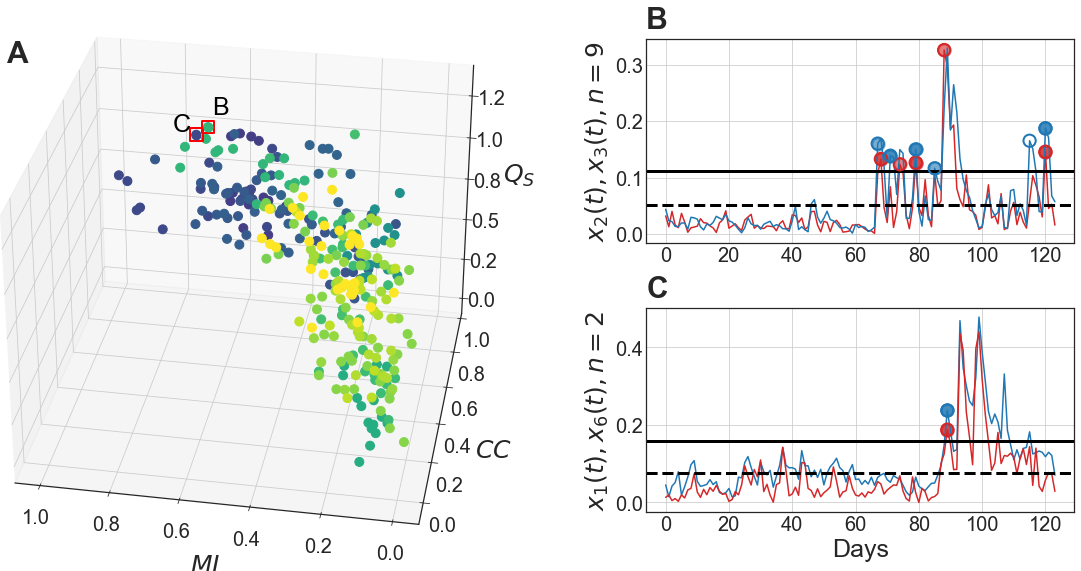

In [124]:
dist_top=[]
for t in titulos_test:
    dist_top.extend([t]*iu1[0].shape[0])
dist_provs=list(combinations(provincias2analyze,2))*topics


cmap = matplotlib.colormaps.get_cmap('viridis')
# ax0 y ax1
p1_sel_ax0,p2_sel_ax0,top_sel_ax0='Cordoba','Tucuman','Diego_Luciani'
p1_sel_ax1,p2_sel_ax1,top_sel_ax1='Buenos Aires','Santiago del estero','Cristina_Kirchner'#'Buenos Aires','Mendoza','Cristina_Kirchner'

dict_text={''.join([p1_sel_ax0,p2_sel_ax0,top_sel_ax0]):'B',
          ''.join([p1_sel_ax1,p2_sel_ax1,top_sel_ax1]):'C'}

fig = plt.figure(figsize=(16, 8))
gs = fig.add_gridspec(2,2,width_ratios=[0.7,0.5])
#primero agrego las series de eventos
ax0 = fig.add_subplot(gs[0,1])
ax0.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

ax1 = fig.add_subplot(gs[1,1])
ax1.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
#el grafico 3D
ax2 = fig.add_subplot(gs[:,0],projection='3d',computed_zorder=False)


# Crear el scatter plot en 3D
dist_xs=[]
dist_ys=[]
dist_zs=[]
dist_colors=[]
top_colors={}
for i,int_top in zip(range(topics),titulos_test):
    #x -> R
    x=dist_r[int_top][iu1].copy()
    dist_xs.extend(x)

    #y -> MI
    y=dist_mi_norm[int_top][iu1].copy()
    dist_ys.extend(y)
    
    #z -> QS
    sublis,_=matrices_topicos[int_top]
    QS=sublis[0] #QS_c,QA_c,C_c,Mnoe_c
    z=QS[iu1].copy()
    dist_zs.extend(z)
    
    #los colores pueden ser por tema con el valor medio de la cant de eventos
    col=valores_medios[i] #def en la fig anterior
    col=col/valores_medios.max()
    top_colors[int_top]=cmap(col)
    cols=[cmap(col) for _ in range(x.shape[0])]   
    dist_colors.extend(cols)
    #o puede ser por dato con la parte superior de la matriz de eventos

    ax2.scatter(x,y,z,s=80,marker='o',c=cols,alpha=1)#,vmax=1)
    
# Agregar un plano en z = 0.8
z_plano_crit = 0.8
x_plano, y_plano = np.meshgrid(np.linspace(min(dist_xs), max(dist_xs), 10), np.linspace(min(dist_ys), max(dist_ys), 10))
z_plano = np.full_like(x_plano, z_plano_crit)

# Identificar y recuadrar los puntos que superan z=0.8
counter=0

#busco el i que maximiza la suma
lista_suma=[ x**2+y**2+z**2 for x,y,z in zip(dist_xs,dist_ys,dist_zs)]
indices_maximos,vals_ords = zip(*sorted(zip(range(len(lista_suma)),lista_suma), reverse=True,key= lambda x: x[1])[:5])
for i in indices_maximos:
    print('Topico: {}; Provincias: {}-{}; Sum**2={}'.format(dist_top[i],dist_provs[i][0],dist_provs[i][1],lista_suma[i]))


indices_max_sel=[]
for i in indices_maximos:
    if ''.join([dist_provs[i][0],dist_provs[i][1],dist_top[i]]) in list(dict_text.keys()):
        indices_max_sel.append(i)
    
for i in range(len(dist_zs)):
    #if (dist_zs[i] > z_plano_crit) and (dist_xs[i] > 0.6) and (dist_ys[i] > 0.6):
    if i in indices_max_sel:
        ax2.scatter(dist_xs[i], dist_ys[i], dist_zs[i], facecolor='none', marker='s', s=160, edgecolor='red',linewidth=2)
        ax2.scatter(dist_xs[i], dist_ys[i], dist_zs[i],s=80,marker='o',color=dist_colors[i],alpha=1)
        counter+=1
        print('SEL: Topico: {}; Provincias: {}-{}; Sum**2={}'.format(dist_top[i],
                            dist_provs[i][0],dist_provs[i][1],lista_suma[i]))

        # problemas para poner flechas en 3D entonces hago referencias
        xi,yi,zi=dist_xs[i], dist_ys[i], dist_zs[i]

        st=dict_text[''.join([dist_provs[i][0],dist_provs[i][1],dist_top[i]])]
        
        if st == 'B':
            posx,posy,posz=xi+0.05,yi-0.005,zi+0.03
            ax2.text(posx,posy,posz,  '%s' % (st), size=fontsize_normal, zorder=1, color='k')
        else:
            posx,posy,posz=xi-0.1,yi+0.05,zi+0.1
            ax2.text(posx,posy,posz,  '%s' % (st), size=fontsize_normal, zorder=1, color='k')


print('Cantidad de eventos superados ',counter)
# Configurar etiquetas
ax2.tick_params(axis='both', which='major', labelsize=fontsize_small)

#ax2.set_xlabel(r'$\rho$',labelpad=10,fontsize=fontsize_normal)
ax2.set_xlabel('$CC$',labelpad=13,fontsize=fontsize_normal)
ax2.set_ylabel('$MI$',labelpad=10,fontsize=fontsize_normal)
ax2.set_zlabel('$Q_{S}$',labelpad=10,fontsize=fontsize_normal)


ax2.zaxis.set_rotate_label(False)
ax2.zaxis.label.set_rotation(0)
ax2.zaxis.set_major_formatter(FormatStrFormatter('%.1f'))

#me los saca de la izq y lo pone a la der
ax2.zaxis.set_ticks_position('lower')
ax2.zaxis.set_label_position('lower')

# Rotar el gráfico 3D
#ax2.view_init(elev=20, azim=230) 
ax2.view_init(elev=30, azim=190)
ax2.set_box_aspect(None, zoom=1.3)
ax2.text2D(x=0, y=0.95, s='A', fontsize=fontsize_big,fontweight='bold', transform=ax2.transAxes)

    
for ax,p1,p2,top_sel,colp1,colp2 in [[ax0,p1_sel_ax0,p2_sel_ax0,top_sel_ax0,'tab:red','tab:blue'],
                                        [ax1,p1_sel_ax1,p2_sel_ax1,top_sel_ax1,'tab:blue','tab:red']]:

    top_ix=titulos_test.index(top_sel)+1
    print(top_ix)
    dfsel=dfs[topics_names.index(top_sel)]
    _,umbrales=matrices_topicos[top_sel]
    th0,th1=umbrales

    y1=dfsel[p1].copy()
    y2=dfsel[p2].copy()

    x1=range(len(y1))
    plot1,=ax.plot(y1,color=colp1,label=p1)
    plot2,=ax.plot(y2,color=colp2,label=p2)
    
    
    ev_array1=ev.event_transform_cristina(y1,th1,th0) #serie binaria de eventos
    indev1=np.nonzero(ev_array1) #posiciones de eventos
    noe_c1=indev1[0].shape[0] #cantidad de eventos

    ev_array2=ev.event_transform_cristina(y2,th1,th0)
    indev2=np.nonzero(ev_array2)
    noe_c2=indev2[0].shape[0]

    y_eventos1=y1.to_numpy()[indev1] #posiciones en el eje y de los eventos
    ax.scatter(indev1,y_eventos1,s=150,facecolors='none', edgecolors=colp1,linewidth=2,zorder=3)
    
    y_eventos2=y2.to_numpy()[indev2]
    ax.scatter(indev2,y_eventos2,s=150,facecolors='none', edgecolors=colp2,linewidth=2,zorder=3)

    indx_a,c_a=ev.func_c(ev_array1,ev_array2,lag=Lag)
    indx_b,c_b=ev.func_c(ev_array2,ev_array1,lag=Lag)
    

    coincidencias_az=[]
    for ev_az in indev2[0]:
        for ev_r in indev1[0]:
            dif= ev_az - ev_r
            if 0<= dif <= Lag:
                #si appendeo ev_az veo los eventos azules sobre rojo
                #si appendeo ev_r veo los eventos en rojo que ven los azules
                coincidencias_az.append(ev_r)
            else:
                coincidencias_az.append('nan')
    coincidencias_az=np.asarray(coincidencias_az)
    coin_az=coincidencias_az[coincidencias_az.astype(str)  != 'nan']
    indx2paint_az=[int(x) for x in coin_az]

    coincidencias_r=[]
    for ev_r in indev1[0]:
        for ev_az in indev2[0]:
            dif= ev_r - ev_az
            if 0<= dif <= Lag:
                coincidencias_r.append(ev_az)
            else:
                coincidencias_r.append('nan')

    coincidencias_r=np.asarray(coincidencias_r)
    coin_r=coincidencias_r[coincidencias_r.astype(str) != 'nan']
    indx2paint_r=[int(x) for x in coin_r]

    evb=y2.to_numpy()[indx2paint_r]
    ax.scatter(indx2paint_r,evb,s=150, color=colp2,linewidth=2,alpha=0.6)
    evb=y1.to_numpy()[indx_b]
    ax.scatter(indx_b,evb,s=150, color=colp1,linewidth=2,alpha=0.6)
    
    evb=y1.to_numpy()[indx2paint_az]
    ax.scatter(indx2paint_az,evb,s=150, color=colp1,linewidth=2,alpha=0.6)
    eva=y2.to_numpy()[indx_a]
    ax.scatter(indx_a,eva,s=150, color=colp2,linewidth=2,alpha=0.6)
    
    int_j1=provincias2analyze.index(p1)+1
    int_j2=provincias2analyze.index(p2)+1
    #st1='x_{}'.format(int_j1)+'(t,{})'.format(top_ix)+', ' + 'x_{}'.format(int_j2)+'(t,{})'.format(top_ix)
    st1='x_{}'.format(int_j1)+'(t)'+', ' + 'x_{}'.format(int_j2)+'(t), n={}'.format(top_ix)
    ax.set_ylabel(r'${}$'.format(st1),fontsize=fontsize_normal)
    
    
    ax.grid()
    ax.tick_params(axis='both', which='major', labelsize=fontsize_small)
    p1_label=provincias2analyze_labels[provincias2analyze.index(p1)]
    p2_label=provincias2analyze_labels[provincias2analyze.index(p2)]
    
    ax.axhline(th1,c='k',ls='-',lw=3)
    ax.axhline(th0,c='k',ls='--',lw=3)

    st=dict_text[''.join([p1,p2,top_sel])]
    ax.text(x=0, y=1.05, s=st, fontsize=fontsize_big,fontweight='bold', transform=ax.transAxes)
ax.set_xlabel('Days',fontsize=fontsize_normal)
    
fig.tight_layout()
fig.subplots_adjust(wspace=0.2)
plt.show()

## Fig 7:

In [181]:
def func_spline(start,end,x,rad=0.2):
    # Start point
    vs=np.asarray(start)
    # End point
    ve=np.asarray(end)
    # Connection vector start->end
    vD=ve-vs
    # Perpendicular vector to vD
    vp=np.asarray([vD[1],-vD[0]]) 
    # Control point: same distance from start and end point, and rad*|vD| from the connection line between start and end
    vc=vs+0.5*vD+rad*vp 
    
    vl=((1-x)**2)*vs+(2*(1-x)*x)*vc+(x**2)*ve
    
    return vl

In [180]:
#busco el i que maximiza la suma
lista_suma=[ x**2+y**2+z**2 for x,y,z in zip(dist_xs,dist_ys,dist_zs)]


#agarro los 30 enlaces más grandes
indices_30,vals_30=zip(*sorted(zip(range(len(lista_suma)),lista_suma),reverse=True,key=lambda x: x[1])[:30])


dict_adys_s_30={}
tops_sel=[dist_top[i] for i in indices_30]
tops_sel=list(set(tops_sel))
for t in tops_sel:
    #construyo una matriz por tema
    S=np.zeros((L_prov, L_prov))
    for inx in indices_30:
        tops2=dist_top[inx]
        p1_2=dist_provs[inx][0]
        p2_2=dist_provs[inx][1]
        if tops2 == t:
            inx_fila=provincias2analyze.index(p2_2)
            inx_col=provincias2analyze.index(p1_2)
            S[inx_fila,inx_col]=1
            S[inx_col,inx_fila]=1

    dict_adys_s_30[t]=S

In [182]:
pos={0:(-58.45,-34.6),1:(-64.18,-31.41),2:(-65.22,-26.82),3:(-68.82,-32.89),4:(-60.7,-31.63),5:(-64.26,-27.79)}
labels=['Buenos \n Aires','Córdoba','Tucumán','Mendoza','Santa Fe','Santiago \n del Estero']
nodos_label2={i:m for i,m in enumerate(labels)}
new_pos_nodes2 = {}
for k,v in pos.items():
    x,y=v
    if labels[k]=='Santiago \n del Estero':
        x_shift,y_shift=2,0.2
        new_pos_nodes2[k]=(x + x_shift, y + y_shift) 
    elif labels[k]=='Santa Fe':
        x_shift,y_shift=1.5, 0.2
        new_pos_nodes2[k]=(x + x_shift, y + y_shift) 
    elif labels[k]=='Buenos \n Aires':
        x_shift,y_shift=0, -0.8
        new_pos_nodes2[k]=(x + x_shift, y + y_shift) 
    elif labels[k]=='Tucumán':
        x_shift,y_shift=2, 0
        new_pos_nodes2[k]=(x + x_shift, y + y_shift) 
    else:
        x_shift,y_shift=-0.5, 0.5
        new_pos_nodes2[k]=(x + x_shift, y + y_shift) 

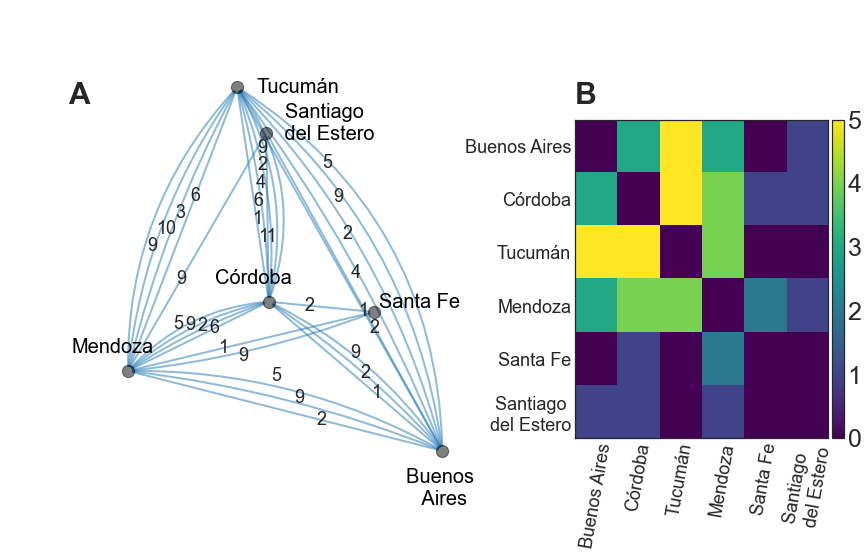

In [183]:
multi_graph = nx.MultiGraph()
matrices=list(dict_adys_s_30.values())
rows=iu1[0]
columns=iu1[1]
# Suponiendo que tienes las matrices de adyacencia en una lista llamada 'matrices'
for et, matrix in dict_adys_s_30.items():
    # Itera sobre las filas y columnas de la matriz para agregar las aristas al multigrafo
    for row,col in zip(iu1[0],iu1[1]):
        # Verifica si hay una conexión en la matriz
        if matrix[row,col] != 0:
            # Agrega la arista con un atributo 'tema' que indica el tema al que pertenece
            #print(row,col,et)
            multi_graph.add_edge(row, col, tema=et)


fig = plt.figure(figsize=(15, 10))
nrows,ncols=5,5
gs = gridspec.GridSpec(nrows=nrows,ncols=ncols,width_ratios=[1,1,1,1,0.5])

ax=fig.add_subplot(gs[:,:3])
ax1=fig.add_subplot(gs[1:4,3:])

list_integers=[dict_titulos[et] for et in dict_adys_s_30.keys()]
fracciones=np.linspace(0,1,len(dict_adys_s_30)+1)
dict_colors={k:v for k,v in zip(dict_adys_s_30.keys(),fracciones)}
#print(dict_colors)
cmap = plt.colormaps.get_cmap('Set1')


ax.set_facecolor('white')
nx.draw_networkx_nodes(multi_graph, pos=pos, ax=ax, node_color = 'k',node_size = 150, alpha = 0.5)

# Works with arc3 and angle3 connectionstyles
connectionstyle = []
for k,v,l,et in list(multi_graph.edges(keys=True,data=True)):
    et=et['tema']
    linecolor='tab:blue'#cmap(dict_colors[et])
    label = dict_titulos[et]
    radio=l
    x0, y0 = pos[k]
    x1, y1 = pos[v]
    arr = mpatches.FancyArrowPatch((x0, y0),(x1, y1),
                                   arrowstyle="-", color=linecolor,linewidth=2,alpha=0.5,
                                    shrinkA=5, shrinkB=5,
                                    patchA=None, patchB=None,
                                    connectionstyle="arc3,rad=rrr".replace('rrr',str(0.2*radio/3)))
    ax.add_patch(arr)
    xs=np.linspace(0,1,num=14)
    inx_mid=int(len(xs)/2)+radio-2
    ys=[func_spline((x0,y0),(x1,y1),x,rad=0.2*radio/3) for x in xs]
    equis=np.asarray(ys)[:,0]
    #dxs=equis[1]-equis[0]
    yies=np.asarray(ys)[:,1]
    ax.annotate("{}".format(label), (equis[inx_mid],yies[inx_mid]), xycoords='data', 
                    ha='center',va='center', fontsize=fontsize_xsmall,)
                    #bbox = dict(boxstyle="round", facecolor='white',edgecolor='white',pad=0))

nx.draw_networkx_labels(multi_graph, pos=new_pos_nodes2,ax=ax, labels=nodos_label2, font_size=fontsize_small, font_color="k",alpha=1)    
ymin,ymax=ax.get_ylim()
xmin,xmax=ax.get_xlim()
scale_factor=0.05
ax.set_xlim(xmin-abs(xmin*scale_factor),xmax+abs(xmax*scale_factor))
ax.set_ylim(ymin-abs(ymin*scale_factor),ymax+abs(ymax*scale_factor))
#ax.set_title(titulo,fontsize=fontsize_big)
ax.axis('off')
ax1.text(x=-2, y=1.05, s='A', fontsize=fontsize_big,fontweight='bold', transform=ax1.transAxes)

    
    
M_ady_pesada=sum(dict_adys_s_30.values())
# Subplot 1: Mostrar la matriz
im=ax1.imshow(M_ady_pesada, cmap='viridis', interpolation='none', aspect='auto')
ax1.set_yticks(range(len(provincias2analyze)),['Buenos Aires','Córdoba','Tucumán','Mendoza','Santa Fe','Santiago \n del Estero'],fontsize=fontsize_xsmall)
ax1.set_xticks(range(len(provincias2analyze)),['Buenos Aires','Córdoba','Tucumán','Mendoza','Santa Fe','Santiago \n del Estero'],fontsize=fontsize_xsmall,rotation=80)
# Añadir una barra de colores
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
cax.tick_params(labelsize=fontsize_normal)
ax1.text(x=0, y=1.05, s='B', fontsize=fontsize_big,fontweight='bold', transform=ax1.transAxes)
    
# Muestra el gráfico
#fig.savefig(r'C:\Users\lucio\Desktop\imagenes_doc\Paper Masoller\Figure7.pdf',bbox_inches='tight')
plt.show()

## Fig 8 y 9

In [187]:
qs_vs_qa={}
dist_qs=[]
dist_qa=[]
dist_gc=[]
dist_te=[]
dist_pgc=[]
dist_pte=[]
dist_colors=[]
for int_top in titulos_test:
    lis,umbrales=matrices_topicos[int_top]
    QS0,QA0,_,_=lis
    #print(int_top)
    #print(QS0)
    #print(QA0)
    QS=QS0.copy()
    QA=QA0.copy()
    
    qs,qa=QS[iu1],np.abs(QA[iu1])
    qs_vs_qa[int_top]=[qs,qa]
    
    dist_qs.extend(qs)
    dist_qa.extend(qa)
    
    dist_colors.extend([top_colors[int_top]]*qs.shape[0])
    
    #GC
    GC=method_matrices['GC'][int_top][0].copy()
    dist_gc.extend(GC.flatten())
    GC_pvals=method_matrices['GC'][int_top][1].copy()
    dist_pgc.extend(GC_pvals.flatten())
    
    #TE
    TE=method_matrices['TE'][int_top][0].copy()
    dist_te.extend(TE.flatten())
    TE_pvals=method_matrices['TE'][int_top][1].copy()
    dist_pte.extend(TE_pvals.flatten())

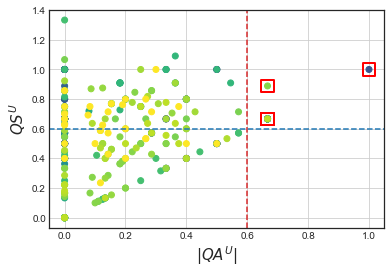

In [189]:
fig, axs = plt.subplots(1,1,figsize=(6,4))

axs.scatter(dist_qa,dist_qs,color=dist_colors,alpha=1)
    
for i in indices_maximos_sel:
    axs.scatter(dist_qa[i],dist_qs[i], facecolor='none', marker='s', s=160, edgecolor='red',linewidth=2)
    
axs.grid(True)
axs.set_ylabel('$QS^{U}$',fontsize=15)
axs.set_xlabel('$|QA^{U}|$',fontsize=15)

qa_ref,qs_ref=0.6,0.6
axs.axvline(qa_ref,ls='--',c='tab:red')
axs.axhline(qs_ref,ls='--',c='tab:blue')

plt.show()

Topico: Avion_Irani; Provincias: Tucuman-Cordoba; TE=0.16, pval TE=0.005
Topico: Diego_Luciani; Provincias: Mendoza-Cordoba; TE=0.143, pval TE=0.005
Topico: Sergio_Massa; Provincias: Tucuman-Cordoba; TE=0.141, pval TE=0.005
Topico: Cambiemos; Provincias: Tucuman-Buenos Aires; TE=0.138, pval TE=0.02
Topico: Planes_Sociales; Provincias: Mendoza-Santa Fe; TE=0.135, pval TE=0.005
Topico: Cristina_Kirchner; Provincias: Buenos Aires-Tucuman; TE=0.131, pval TE=0.025
Topico: Paro; Provincias: Mendoza-Buenos Aires; TE=0.127, pval TE=0.005
Topico: Planes_Sociales; Provincias: Tucuman-Cordoba; TE=0.124, pval TE=0.005
Topico: Inflacion; Provincias: Cordoba-Tucuman; TE=0.12, pval TE=0.03
Topico: Avion_Irani; Provincias: Buenos Aires-Santa Fe; TE=0.118, pval TE=0.005
Topico: Juan_Manzur; Provincias: Santa Fe-Tucuman; TE=0.117, pval TE=0.005
Topico: Diego_Luciani; Provincias: Santiago del estero-Cordoba; TE=0.115, pval TE=0.005
Topico: Planes_Sociales; Provincias: Buenos Aires-Cordoba; TE=0.114, pval

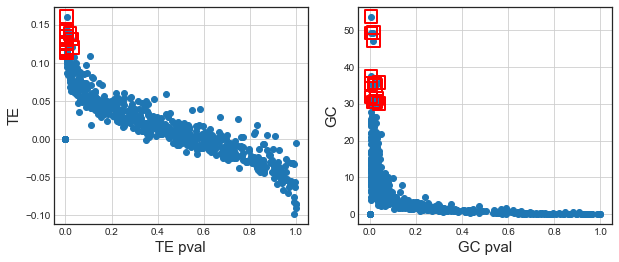

In [190]:
dist_top2=[]
for t in titulos_test:
    dist_top2.extend([t]*L_prov*L_prov)
dist_provs2=[]
for p1 in provincias2analyze:
    for p2 in provincias2analyze:
        dist_provs2.append((p1,p2))
dist_provs2=[dist_provs2]*topics
dist_provs2=[el for sub in dist_provs2 for el in sub]

#dame los 10 máximos
top_rank=len(indices_maximos_sel)
indices_maximos_sel_te,vals_ords_sel_te = zip(*sorted(zip(range(len(dist_te)),dist_te), reverse=True,key= lambda x: x[1])[:top_rank])
indices_maximos_sel_gc,vals_ords_sel_gc = zip(*sorted(zip(range(len(dist_gc)),dist_gc), reverse=True,key= lambda x: x[1])[:top_rank])

for i in indices_maximos_sel_te:
    print('Topico: {}; Provincias: {}-{}; TE={}, pval TE={}'.format(dist_top2[i],
                                        dist_provs2[i][0],dist_provs2[i][1],np.round(dist_te[i],3),np.round(dist_pte[i],3)))

print('\n')
for i in indices_maximos_sel_gc:
    print('Topico: {}; Provincias: {}-{}; GC={}, pval GC={}'.format(dist_top2[i],
                                        dist_provs2[i][0],dist_provs2[i][1],np.round(dist_gc[i],3),np.round(dist_pgc[i],3)))
    
    
fig, axs = plt.subplots(1,2,figsize=(10,4))

ax0,ax1=axs

ax0.scatter(dist_pte,dist_te,alpha=1)  
for i in indices_maximos_sel_te:
    ax0.scatter(dist_pte[i],dist_te[i], facecolor='none', marker='s', s=160, edgecolor='red',linewidth=2)
ax0.grid(True)
ax0.set_ylabel('TE',fontsize=15)
ax0.set_xlabel('TE pval',fontsize=15)

ax1.scatter(dist_pgc,dist_gc,alpha=1)  
for i in indices_maximos_sel_gc:
    ax1.scatter(dist_pgc[i],dist_gc[i], facecolor='none', marker='s', s=160, edgecolor='red',linewidth=2)
ax1.grid(True)
ax1.set_ylabel('GC',fontsize=15)
ax1.set_xlabel('GC pval',fontsize=15)

plt.show()

In [191]:
redes_DI={}
redes_DI_pvals={}
#cual es el pvalor máximo para esta elección de 10 enlaces?
matrices_DI_completas={}
valores_analogos_qa={}
valores_analogos_te={}
valores_analogos_gc={}
for int_top in titulos_test:

    
    GC_pvals=method_matrices['GC'][int_top][1].copy()
    TE_pvals=method_matrices['TE'][int_top][1].copy()
    
    TE=method_matrices['TE'][int_top][0].copy()
    GC=method_matrices['GC'][int_top][0].copy()


    
    lis,umbrales=matrices_topicos[int_top]
    _,QA,_,_=lis
    
    
    A_te=np.zeros((L_prov, L_prov))
    P_te=np.zeros((L_prov, L_prov))
    
    A_gc=np.zeros((L_prov, L_prov))
    P_gc=np.zeros((L_prov, L_prov))
    
    QA_A=np.zeros((L_prov, L_prov))
    
    for inx_qa in indices_maximos_sel:
        top_el_qa=dist_top[inx_qa]
        inx_fila_qa=provincias2analyze.index(dist_provs[inx_qa][0])
        inx_col_qa=provincias2analyze.index(dist_provs[inx_qa][1])
        
        if top_el_qa == int_top:
            QA_A[inx_fila_qa,inx_col_qa]=QA[inx_fila_qa,inx_col_qa]
            QA_A[inx_col_qa,inx_fila_qa]=QA[inx_col_qa,inx_fila_qa]

    for inx_te in indices_maximos_sel_te:        
        top_el_te=dist_top2[inx_te]
        inx_fila_te=provincias2analyze.index(dist_provs2[inx_te][0])
        inx_col_te=provincias2analyze.index(dist_provs2[inx_te][1])
        
        if top_el_te == int_top:
            A_te[inx_fila_te,inx_col_te]=TE[inx_fila_te,inx_col_te]
            P_te[inx_fila_te,inx_col_te]=TE_pvals[inx_fila_te,inx_col_te]

    for inx_gc in indices_maximos_sel_gc:
        top_el_gc=dist_top2[inx_gc]
        inx_fila_gc=provincias2analyze.index(dist_provs2[inx_gc][0])
        inx_col_gc=provincias2analyze.index(dist_provs2[inx_gc][1])

        if top_el_gc == int_top:
            A_gc[inx_fila_gc,inx_col_gc]=GC[inx_fila_gc,inx_col_gc]
            P_gc[inx_fila_gc,inx_col_gc]=GC_pvals[inx_fila_gc,inx_col_gc]

    QA_A[QA_A<0]=0   
    QA_A=QA_A.T
    

    fqa,cqa=np.where(QA_A!=0)
    valores_analogos_qa[int_top]=[fqa,cqa,TE,TE_pvals]
    QA_sel=QA.copy()

    fgc,cgc=np.where(A_gc!=0)
    valores_analogos_gc[int_top]=[fgc,cgc,QA,GC,TE]
    
    fte,cte=np.where(A_te!=0)
    valores_analogos_te[int_top]=[fte,cte,QA,GC,TE]
    
    redes_DI[int_top]=[A_te,A_gc,QA_A]
    redes_DI_pvals[int_top]=[P_te,P_gc]


C:\Users\lucio\AppData\Local\Temp\ipykernel_13440\534514971.py:19: RuntimeWarning: invalid value encountered in divide
  DI_TE=(TE-TE.T)/(TE+TE.T)
C:\Users\lucio\AppData\Local\Temp\ipykernel_13440\534514971.py:20: RuntimeWarning: invalid value encountered in divide
  DI_GC=(GC-GC.T)/(GC+GC.T)


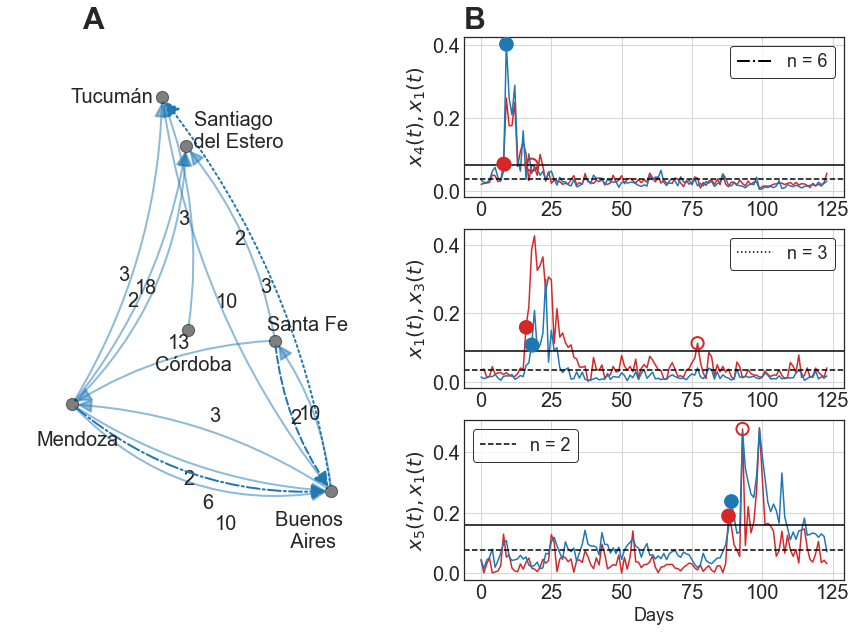

In [239]:
pos={0:(-58.45,-34.6),1:(-64.18,-31.41),2:(-65.22,-26.82),3:(-68.82,-32.89),4:(-60.7,-31.63),5:(-64.26,-27.79)}
labels=['Buenos \n Aires','Córdoba','Tucumán','Mendoza','Santa Fe','Santiago \n del Estero']
nodos_label2={i:m for i,m in enumerate(labels)}
new_pos_nodes2 = {}
for k,v in pos.items():
    x,y=v
    if labels[k]=='Santiago \n del Estero':
        x_shift,y_shift=2,0.3
        new_pos_nodes2[k]=(x + x_shift, y + y_shift) 
    elif labels[k]=='Santa Fe':
        x_shift,y_shift=1.3, 0.3
        new_pos_nodes2[k]=(x + x_shift, y + y_shift) 
    elif labels[k]=='Buenos \n Aires':
        x_shift,y_shift=-0.8, -0.8
        new_pos_nodes2[k]=(x + x_shift, y + y_shift) 
    elif labels[k]=='Tucumán':
        x_shift,y_shift=-2, 0
        new_pos_nodes2[k]=(x + x_shift, y + y_shift) 
    else:
        x_shift,y_shift=0.2, -0.7
        new_pos_nodes2[k]=(x + x_shift, y + y_shift) 

fig = plt.figure(figsize=(15, 10))

nrows,ncols=3,2
gs = gridspec.GridSpec(nrows=nrows,ncols=ncols)
        
met='QA'

dict2graf= {k:v[2] for k,v in redes_DI.items()}



axis=[]
for fila in range(nrows):
    for column in range(ncols):
        if (fila == 0) and (column == 0):
            ax_center=fig.add_subplot(gs[0:3,column])

            # Crear un multigrafo vacío
            multi_graph = nx.MultiDiGraph()

            #matrices=np.asarray(list(dict_adys.values()))
            # Iterar sobre las matrices de adyacencia y agregar los bordes al multigrafo
            for et,matrix in dict2graf.items():
                graph = nx.from_numpy_matrix(matrix, create_using=nx.MultiDiGraph)
                multi_graph.add_edges_from(graph.edges(), tema=et)

            multi_graph.remove_edges_from(nx.selfloop_edges(multi_graph))

            ax_center.set_facecolor('white')
            nx.draw_networkx_nodes(range(len(provincias2analyze)), pos=pos, ax=ax_center, node_color = 'k',node_size = 150, alpha = 0.5)
            
            for k,v,l,et in list(multi_graph.edges(keys=True,data=True)):
                et=et['tema']
                label = dict_titulos[et]
                radio=l+2
                
                if (label == 2 and k==4 and v==0):
                    linecolor='tab:blue'#'darkorange'
                    alpha=1
                    zorder=5
                    linestyle='--'
                elif (label == 3 and k==0 and v==2):
                    linecolor='tab:blue'#'green'
                    alpha=1
                    zorder=5
                    linestyle=':'
                elif (label ==6 and k==3 and v==0):
                    linecolor='tab:blue'#'darkred'
                    alpha=1
                    zorder=5
                    linestyle='-.'
                else:
                    linecolor='tab:blue'
                    alpha=0.5
                    zorder=1
                    linestyle='-'

                x0, y0 = pos[k]
                x1, y1 = pos[v]

                arr = mpatches.FancyArrowPatch((x0, y0),(x1, y1),
                                               arrowstyle="-|>", color=linecolor,linewidth=2,alpha=alpha,
                                                shrinkA=5, shrinkB=5,mutation_scale=30,linestyle=linestyle,
                                                patchA=None, patchB=None,zorder=zorder,
                                                connectionstyle="arc3,rad=rrr".replace('rrr',str(0.2*radio/3)))
                ax_center.add_patch(arr)

                xs=np.linspace(0,1,num=14)
                inx_mid=int(len(xs)/2)+radio-3

                ys=[func_spline((x0,y0),(x1,y1),x,rad=0.2*radio/3) for x in xs]
                equis=np.asarray(ys)[:,0]
                #dxs=equis[1]-equis[0]
                yies=np.asarray(ys)[:,1]

                ax_center.annotate("{}".format(label), (equis[inx_mid],yies[inx_mid]), xycoords='data', 
                               ha='center',va='center', fontsize=fontsize_small,zorder=5)


            ymin,ymax=ax_center.get_ylim()
            xmin,xmax=ax_center.get_xlim()

            scale_factor=0.03
            ax_center.set_xlim(xmin-abs(xmin*scale_factor),xmax+abs(xmax*scale_factor))
            ax_center.set_ylim(ymin-abs(ymin*scale_factor),ymax+abs(ymax*scale_factor))
            
            #ax_center.set_zorder(20)
            #nx.draw_networkx_labels(multi_graph, pos=new_pos_nodes2,ax=ax_center, labels=nodos_label2,
            #                    font_size=fontsize_small, font_color="k",alpha=1)    
            
            for key,value in new_pos_nodes2.items():
                x,y=value
                ax_center.annotate(nodos_label2[key], (x,y), xycoords='data', 
                                   ha='center',va='center', fontsize=fontsize_small,zorder=5)
            ax_center.axis('off')
            
        elif (fila > 0) and (column == 0):
            pass
        else:
            axis.append(fig.add_subplot(gs[fila,column]))

    
    
for ax,sub in list(zip(axis,[(3, 0, 1, {'tema': 'Gasoducto'}),(0, 2, 0, {'tema': 'Avion_Irani'}),(4, 0, 0, {'tema': 'Cristina_Kirchner'})])):
    k,v,l,et=sub
    int_top=et['tema']
    colp1='tab:red'
    colp2='tab:blue'
    label_top = dict_titulos[int_top]        
    j1=provincias2analyze[k]
    j2=provincias2analyze[v]

    dfsel=dfs[topics_names.index(int_top)]
    _,umbrales=matrices_topicos[int_top]
    th0,th1=umbrales

    y1=dfsel[j1].copy()
    y2=dfsel[j2].copy()

    x1=range(len(y1))
    p1,=ax.plot(y1,color=colp1,label=j1)
    p2,=ax.plot(y2,color=colp2,label=j2)

    ev_array1=ev.event_transform_cristina(y1,th1,th0)
    indev1=np.nonzero(ev_array1)
    noe_c1=indev1[0].shape[0]

    eventos1=dfsel[j1].to_numpy()[indev1]
    ax.scatter(indev1,eventos1,s=150,facecolors='none', edgecolors=colp1,linewidth=2,zorder=3)


    ev_array2=ev.event_transform_cristina(y2,th1,th0)
    indev2=np.nonzero(ev_array2)
    noe_c2=indev2[0].shape[0]

    eventos2=dfsel[j2].to_numpy()[indev2]
    ax.scatter(indev2,eventos2,s=150,facecolors='none', edgecolors=colp2,linewidth=2,zorder=3)


    indx_a,c_a=ev.func_c(ev_array1,ev_array2,lag=Lag)
    indx_b,c_b=ev.func_c(ev_array2,ev_array1,lag=Lag)

    eventos_totales=(noe_c1+noe_c2)

    if int_top == 'Diego_Luciani':
        if eventos_totales != 0:
            s= 2*(c_b + c_a)/eventos_totales
            a= 2*(c_b - c_a)/eventos_totales
        else:
            s=0
            a=0
        print(j1,j2,s,a)


    coincidencias_az=[]
    for ev_az in indev2[0]:
        for ev_r in indev1[0]:
            dif= ev_az - ev_r
            if 0<= dif <= Lag:
                #si appendeo ev_az veo los eventos azules sobre rojo
                #si appendeo ev_r veo los eventos en rojo que ven los azules
                coincidencias_az.append(ev_r)
            else:
                coincidencias_az.append('nan')
    coincidencias_az=np.asarray(coincidencias_az)
    coin_az=coincidencias_az[coincidencias_az.astype(str)  != 'nan']
    indx2paint_az=[int(x) for x in coin_az]

    evb=dfsel[j1].to_numpy()[indx2paint_az]
    ax.scatter(indx2paint_az,evb,s=150, color=colp1,linewidth=2,zorder=3)

    coincidencias_r=[]
    for ev_r in indev1[0]:
        for ev_az in indev2[0]:
            dif= ev_r - ev_az
            if 0<= dif <= Lag:
                coincidencias_r.append(ev_az)
            else:
                coincidencias_r.append('nan')

    coincidencias_r=np.asarray(coincidencias_r)
    coin_r=coincidencias_r[coincidencias_r.astype(str) != 'nan']
    indx2paint_r=[int(x) for x in coin_r]
    evb=dfsel[j2].to_numpy()[indx2paint_r]

    
    eva=dfsel[j2].to_numpy()[indx_a]
    ax.scatter(indx_a,eva,s=150, color=colp2,linewidth=2,zorder=3)


    ax.axhline(th1,c='k',ls='-',lw=1.5)
    ax.axhline(th0,c='k',ls='--',lw=1.5)
    
    ax.grid(True)
    st1='x_{}'.format(k+1)
    st2='x_{}'.format(v+1)

    st=st1 + '(t) , ' + st2 + '(t)'# , n={}'.format(label_top)
    ax.set_ylabel(r'${}$'.format(st),fontsize=fontsize_small)
    ax.tick_params(axis='y', which='major', labelsize=fontsize_small)
    ax.tick_params(axis='both', which='major', labelsize=fontsize_small)
    
    if (label_top == 2 and k==4 and v==0):
        linecolor='tab:blue'#'darkorange'
        linestyle='--'
        dotted_line = mlines.Line2D([], [], color='k', linestyle=linestyle, label='n = {}'.format(label_top))
        ax.legend(handles=[dotted_line],frameon=True,facecolor='white',fontsize=fontsize_xsmall,edgecolor='k')

    elif (label_top == 3 and k==0 and v==2):
        linecolor='tab:blue'#'green'
        linestyle=':'
        dotted_line = mlines.Line2D([], [], color='k', linestyle=linestyle, label='n = {}'.format(label_top))
        ax.legend(handles=[dotted_line],frameon=True,facecolor='white',fontsize=fontsize_xsmall,edgecolor='k')

    elif (label_top ==6 and k==3 and v==0):
        linecolor='tab:blue'#'darkred'
        linestyle='-.'
        dotted_line = mlines.Line2D([], [], color='k', linestyle=linestyle, label='n = {}'.format(label_top),linewidth=2)
        ax.legend(handles=[dotted_line],frameon=True,facecolor='white',fontsize=fontsize_xsmall,edgecolor='k')


ax.set_xlabel('Days',fontsize=fontsize_xsmall)
 
ax_center.text(x=-1, y=1.05, s='A', fontsize=fontsize_big,fontweight='bold', transform=axis[0].transAxes)
axis[0].text(x=0, y=1.05, s='B', fontsize=fontsize_big,fontweight='bold', transform=axis[0].transAxes)


plt.subplots_adjust(hspace=0.2,wspace=0.2)
plt.show()

5 2 1
8 4 2
6 3 2


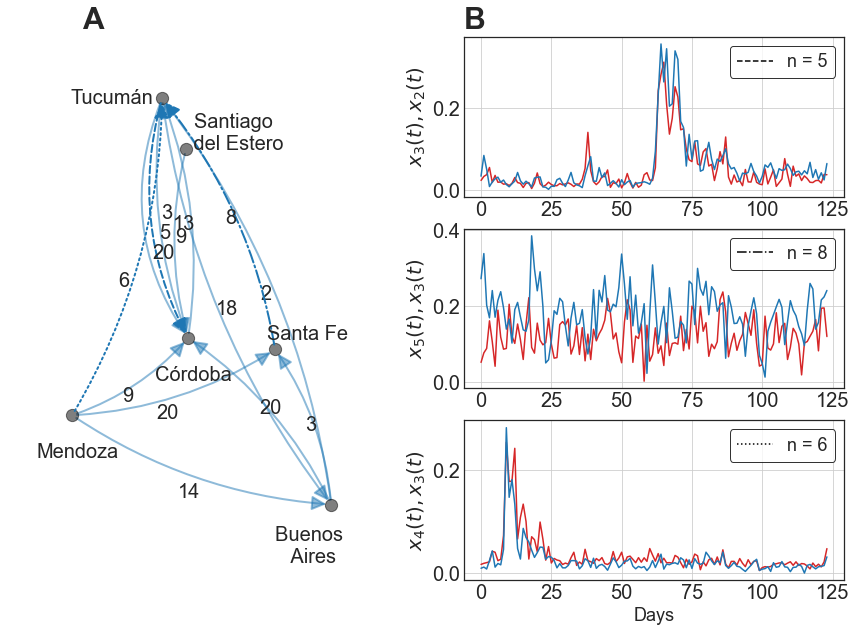

In [41]:
pos={0:(-58.45,-34.6),1:(-64.18,-31.41),2:(-65.22,-26.82),3:(-68.82,-32.89),4:(-60.7,-31.63),5:(-64.26,-27.79)}
labels=['Buenos \n Aires','Córdoba','Tucumán','Mendoza','Santa Fe','Santiago \n del Estero']
nodos_label2={i:m for i,m in enumerate(labels)}
new_pos_nodes2 = {}
for k,v in pos.items():
    x,y=v
    if labels[k]=='Santiago \n del Estero':
        x_shift,y_shift=2,0.3
        new_pos_nodes2[k]=(x + x_shift, y + y_shift) 
    elif labels[k]=='Santa Fe':
        x_shift,y_shift=1.3, 0.3
        new_pos_nodes2[k]=(x + x_shift, y + y_shift) 
    elif labels[k]=='Buenos \n Aires':
        x_shift,y_shift=-0.8, -0.8
        new_pos_nodes2[k]=(x + x_shift, y + y_shift) 
    elif labels[k]=='Tucumán':
        x_shift,y_shift=-2, 0
        new_pos_nodes2[k]=(x + x_shift, y + y_shift) 
    else:
        x_shift,y_shift=0.2, -0.7
        new_pos_nodes2[k]=(x + x_shift, y + y_shift) 

fig = plt.figure(figsize=(15, 10))

nrows,ncols=3,2
gs = gridspec.GridSpec(nrows=nrows,ncols=ncols)
        
met='TE' # 'GC', 'TE'

if met == 'GC':
    dict2graf= {k:v[1] for k,v in redes_DI.items()}
elif met =='TE':
    dict2graf= {k:v[0] for k,v in redes_DI.items()}

axis=[]
for fila in range(nrows):
    for column in range(ncols):
        if (fila == 0) and (column == 0):
            ax_center=fig.add_subplot(gs[0:3,column])

            # Crear un multigrafo vacío
            multi_graph = nx.MultiDiGraph()

            #matrices=np.asarray(list(dict_adys.values()))
            # Iterar sobre las matrices de adyacencia y agregar los bordes al multigrafo
            for et,matrix in dict2graf.items():
                graph = nx.from_numpy_matrix(matrix, create_using=nx.MultiDiGraph)
                multi_graph.add_edges_from(graph.edges(), tema=et)

            multi_graph.remove_edges_from(nx.selfloop_edges(multi_graph))

            ax.set_facecolor('white')
            nx.draw_networkx_nodes(range(len(provincias2analyze)), pos=pos, ax=ax_center, node_color = 'k',node_size = 150, alpha = 0.5)


            for k,v,l,et in list(multi_graph.edges(keys=True,data=True)):
                et=et['tema']
                label = dict_titulos[et]
                radio=l+2
                
                
                if met == 'TE':
                    if (label == 5 and k==2 and v==1):
                        linecolor='tab:blue'#'darkorange'
                        alpha=1
                        zorder=5
                        linestyle='--'
                    elif (label == 6 and k==3 and v==2):
                        linecolor='tab:blue'#'green'
                        alpha=1
                        zorder=5
                        linestyle=':'
                    elif (label ==8 and k==4 and v==2):
                        linecolor='tab:blue'#'darkred'
                        alpha=1
                        zorder=5
                        linestyle='-.'
                    else:
                        linecolor='tab:blue'
                        alpha=0.5
                        zorder=1
                        linestyle='-'
                elif met == 'GC':
                    if (label == 3 and k==3 and v==4):
                        linecolor='tab:blue'#'darkorange'
                        alpha=1
                        zorder=5
                        linestyle='--'
                    elif (label == 4 and k==0 and v==5):
                        linecolor='tab:blue'#'green'
                        alpha=1
                        zorder=5
                        linestyle=':'
                    elif (label ==9 and k==3 and v==1):
                        linecolor='tab:blue'#'darkred'
                        alpha=1
                        zorder=5
                        linestyle='-.'
                    else:
                        linecolor='tab:blue'
                        alpha=0.5
                        zorder=1    
                        linestyle='-'

                x0, y0 = pos[k]
                x1, y1 = pos[v]

                arr = mpatches.FancyArrowPatch((x0, y0),(x1, y1),
                                               arrowstyle="-|>", color=linecolor,linewidth=2,alpha=alpha,
                                                shrinkA=5, shrinkB=5,mutation_scale=30,linestyle=linestyle,
                                                patchA=None, patchB=None,zorder=zorder,
                                                connectionstyle="arc3,rad=rrr".replace('rrr',str(0.2*radio/3)))
                ax_center.add_patch(arr)

                xs=np.linspace(0,1,num=14)
                inx_mid=int(len(xs)/2)+radio-3

                ys=[func_spline((x0,y0),(x1,y1),x,rad=0.2*radio/3) for x in xs]
                equis=np.asarray(ys)[:,0]
                #dxs=equis[1]-equis[0]
                yies=np.asarray(ys)[:,1]

                ax_center.annotate("{}".format(label), (equis[inx_mid],yies[inx_mid]), xycoords='data', 
                               ha='center',va='center', fontsize=fontsize_small,zorder=5)


            ymin,ymax=ax_center.get_ylim()
            xmin,xmax=ax_center.get_xlim()

            scale_factor=0.03
            ax_center.set_xlim(xmin-abs(xmin*scale_factor),xmax+abs(xmax*scale_factor))
            ax_center.set_ylim(ymin-abs(ymin*scale_factor),ymax+abs(ymax*scale_factor)) 
            
            for key,value in new_pos_nodes2.items():
                x,y=value
                ax_center.annotate(nodos_label2[key], (x,y), xycoords='data', 
                                   ha='center',va='center', fontsize=fontsize_small,zorder=5)
            ax_center.axis('off')
            
        elif (fila > 0) and (column == 0):
            pass
        #elif (fila == 0) and (column == 1):
        #    pass
        else:
            axis.append(fig.add_subplot(gs[fila,column]))


if met =='TE':
    list2graf=list(zip(axis,[(2, 1, 1, {'tema': 'Sergio_Massa'}), (4, 2, 0, {'tema': 'Juan_Manzur'}), (3, 2, 0, {'tema': 'Gasoducto'})]))
else:
    list2graf=list(zip(axis,[(3, 1, 1, {'tema': 'Diego_Luciani'}), (3, 4, 0, {'tema': 'Avion_Irani'}), (0, 5, 0, {'tema': 'Silvina_Batakis'})]))

for ax,sub in list2graf:
    k,v,l,et=sub
    int_top=et['tema']
    colp1='tab:red'
    colp2='tab:blue'
    label_top = dict_titulos[int_top]        
    j1=provincias2analyze[k]
    j2=provincias2analyze[v]

    dfsel=dfs[topics_names.index(int_top)]

    y1=dfsel[j1].copy()
    y2=dfsel[j2].copy()

    x1=range(len(y1))
    plot1,=ax.plot(y1,color=colp1,label=j1)
    plot2,=ax.plot(y2,color=colp2,label=j2)

    ax.grid(True)
    st1='x_{}'.format(k+1)
    st2='x_{}'.format(v+1)

    st=st1 + '(t) , ' + st2 + '(t) '#, n={}'.format(label_top)
    ax.set_ylabel(r'${}$'.format(st),fontsize=fontsize_small)
    ax.tick_params(axis='y', which='major', labelsize=fontsize_small)
    ax.tick_params(axis='both', which='major', labelsize=fontsize_small)
    
    if met == 'TE':
        if (label_top == 5 and k==2 and v==1):
            linestyle='--'
            dotted_line = mlines.Line2D([], [], color='k', linestyle=linestyle, label='n = {}'.format(label_top))
            ax.legend(handles=[dotted_line],frameon=True,facecolor='white',fontsize=fontsize_xsmall,edgecolor='k')

        elif (label_top == 6 and k==3 and v==2):
            linestyle=':'
            dotted_line = mlines.Line2D([], [], color='k', linestyle=linestyle, label='n = {}'.format(label_top))
            ax.legend(handles=[dotted_line],frameon=True,facecolor='white',fontsize=fontsize_xsmall,edgecolor='k')

        elif (label_top ==8 and k==4 and v==2):
            linestyle='-.'
            dotted_line = mlines.Line2D([], [], color='k', linestyle=linestyle, label='n = {}'.format(label_top))
            ax.legend(handles=[dotted_line],frameon=True,facecolor='white',fontsize=fontsize_xsmall,edgecolor='k')

    elif met == 'GC':
        if (label_top == 3 and k==3 and v==4):
            linestyle='--'
            dotted_line = mlines.Line2D([], [], color='k', linestyle=linestyle, label='n = {}'.format(label_top),linewidth=2)
            ax.legend(handles=[dotted_line],frameon=True,facecolor='white',fontsize=fontsize_xsmall,edgecolor='k')

        elif (label_top ==4 and k==0 and v==5):
            linestyle=':'
            dotted_line = mlines.Line2D([], [], color='k', linestyle=linestyle, label='n = {}'.format(label_top),linewidth=2)
            ax.legend(handles=[dotted_line],frameon=True,facecolor='white',fontsize=fontsize_xsmall,edgecolor='k')

        elif (label_top ==9 and k==3 and v==1):
            linestyle='-.'
            dotted_line = mlines.Line2D([], [], color='k', linestyle=linestyle, label='n = {}'.format(label_top),linewidth=2)
            ax.legend(handles=[dotted_line],frameon=True,facecolor='white',fontsize=fontsize_xsmall,edgecolor='k')


ax.set_xlabel('Days',fontsize=fontsize_xsmall)
 

#plt.suptitle('TE',fontsize=fontsize_big)
plt.subplots_adjust(hspace=0.2,wspace=0.2)
ax_center.text(x=-1, y=1.05, s='A', fontsize=fontsize_big,fontweight='bold', transform=axis[0].transAxes)
axis[0].text(x=0, y=1.05, s='B', fontsize=fontsize_big,fontweight='bold', transform=axis[0].transAxes)
plt.show()

## Material Suplementario:

## WC

In [64]:
from wordcloud import WordCloud
import json

In [65]:
#Check the wordclouds
with open(r'...\series_H20.npy', 'rb') as f:
    H=np.load(f,allow_pickle=True)    
    
# Opening index term dictionary
f = open(r'...\ind2term.json')
ind2term = json.load(f)

etiquetas_tops_ord=['Alberto_Fernandez','Diego_Luciani','Cambiemos','Sabag_Montiel','Avion_Irani',
           'Inflacion','Dolar','Sergio_Massa','Silvina_Batakis','Planes_Sociales',
           'Corte_Suprema','Cumbre_EEUU','Gasoducto','Javier_Milei','Milagro_Sala',
           'Combustible','Subsidio_Energia','Paro','Cristina_Kirchner','Juan_Manzur']


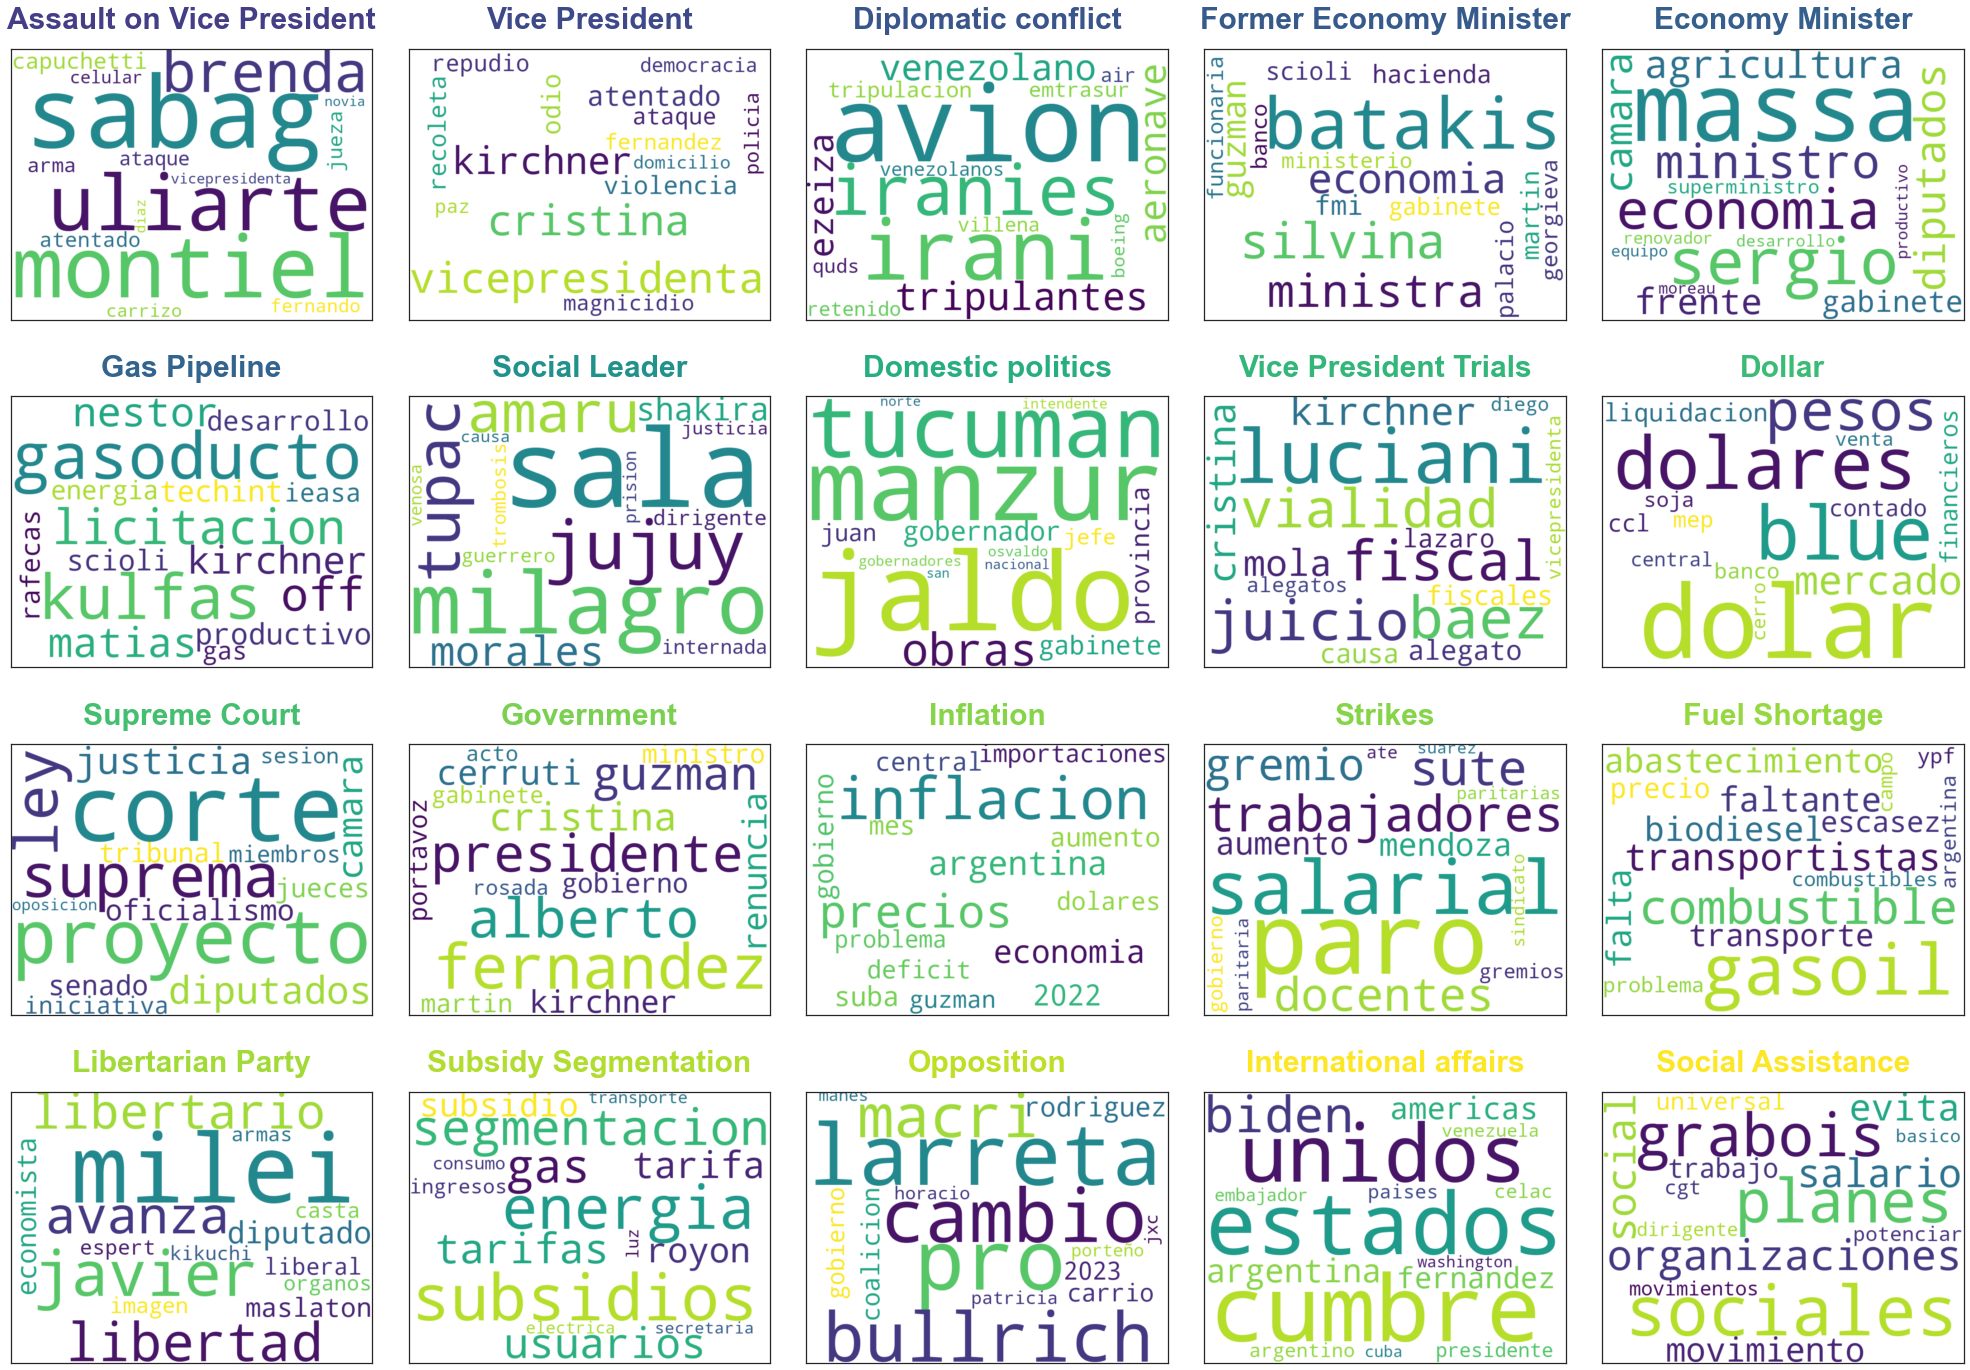

In [73]:
nkeywords=15
        
colores=np.asarray(valores_medios_ordenados)/np.asarray(valores_medios_ordenados).max()
cmap = plt.colormaps.get_cmap('viridis')
xticks_ords=[titulos_test[x] for x in indices_ordenados]

wordcloud_dict={'background_color':'white',
    'width':800,
    'height':600,
    'max_words':200,  # Ajusta la cantidad de palabras que deseas mostrar
    'colormap':'viridis_r',  # Puedes cambiar el esquema de colores
    'contour_color':'black',  # Color del contorno de las palabras
    }

    
fig, axes = plt.subplots(4, 5, figsize=(35, 25))
axinx=[]
axiny=[]
for i in range(4):
    for j in range(5):
        axinx.append(i)
        axiny.append(j)

for name,col,xind,yind in zip(xticks_ords,colores,axinx,axiny):
    topic=etiquetas_tops_ord.index(name)
    ax=axes[xind,yind]

    title=topics_labels[name]

    topic_keywords_index = sorted(range(H.shape[1]), reverse=True, key = lambda x: H[topic][x])[:nkeywords]
    
    palabrasimpo={}
    for tk in topic_keywords_index:
        palabrasimpo[ind2term['{}'.format(tk)]]=H[topic][tk]

    wordcloud = WordCloud(**wordcloud_dict,random_state=100).generate_from_frequencies(palabrasimpo)
    ax.imshow(wordcloud, interpolation='bilinear')
    
    ax.set_title(title,color=cmap(col),fontsize=fontsize_big,fontweight='bold',y=1.05,alpha=1)
    ax.set_xticks([])
    ax.set_yticks([])

    
plt.subplots_adjust(wspace=0.1,hspace=0.1)

plt.show()

## Series y redes

In [206]:
#Hago 10 enlaces más importantes simétricos y muestro sus series
#busco el i que maximiza la suma
lista_suma=[ x**2+y**2+z**2 for x,y,z in zip(dist_xs,dist_ys,dist_zs)]


#agarro los 30 enlaces más grandes
indices_10,vals_10=zip(*sorted(zip(range(len(lista_suma)),lista_suma),reverse=True,key=lambda x: x[1])[:10])


dict_adys_s_10={}
tops_sel=[dist_top[i] for i in indices_10]
tops_sel=list(set(tops_sel))
for t in tops_sel:
    #construyo una matriz por tema
    S=np.zeros((L_prov, L_prov))
    for inx in indices_10:
        tops2=dist_top[inx]
        p1_2=dist_provs[inx][0]
        p2_2=dist_provs[inx][1]
        if tops2 == t:
            inx_fila=provincias2analyze.index(p2_2)
            inx_col=provincias2analyze.index(p1_2)
            S[inx_fila,inx_col]=1
            S[inx_col,inx_fila]=1

    dict_adys_s_10[t]=S

Topico, P1, P2, S, A, S**2
Sabag_Montiel Buenos Aires Tucuman 1.0 0.0 2.43349109358745
Topico, P1, P2, S, A, S**2
Cristina_Kirchner Buenos Aires Cordoba 0.6666666666666666 0.0 2.3837300121445306
Topico, P1, P2, S, A, S**2
Cristina_Kirchner Buenos Aires Mendoza 0.6666666666666666 0.6666666666666666 2.3635043077458953
[88] [] [] [89]
Topico, P1, P2, S, A, S**2
Diego_Luciani Buenos Aires Mendoza 0.9090909090909091 -0.18181818181818182 2.302286694850575
Topico, P1, P2, S, A, S**2
Cristina_Kirchner Buenos Aires Santiago del estero 1.0 0.0 2.295308579235486
Topico, P1, P2, S, A, S**2
Silvina_Batakis Tucuman Cordoba 0.8 0.0 2.2923163823585595
Topico, P1, P2, S, A, S**2
Diego_Luciani Tucuman Cordoba 1.0909090909090908 -0.36363636363636365 2.273573748020243
Topico, P1, P2, S, A, S**2
Diego_Luciani Tucuman Mendoza 1.0 -0.5 2.265284218074913
Topico, P1, P2, S, A, S**2
Sabag_Montiel Mendoza Santa Fe 1.0 0.5 2.2524664799091045
Topico, P1, P2, S, A, S**2
Sergio_Massa Mendoza Cordoba 1.0 0.0 2.235058

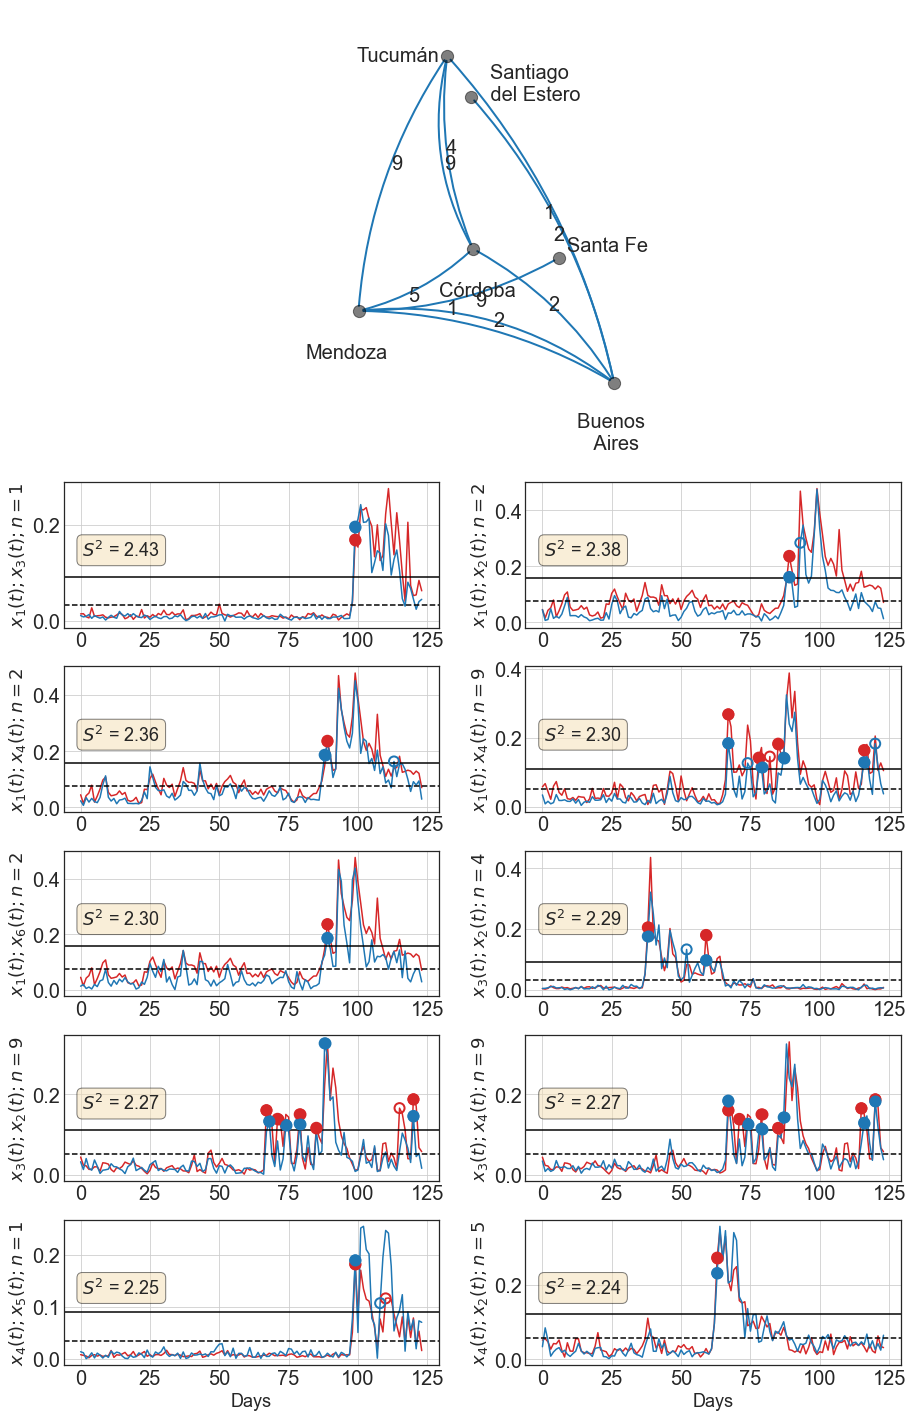

In [241]:
pos={0:(-58.45,-34.6),1:(-64.18,-31.41),2:(-65.22,-26.82),3:(-68.82,-32.89),4:(-60.7,-31.63),5:(-64.26,-27.79)}
labels=['Buenos \n Aires','Córdoba','Tucumán','Mendoza','Santa Fe','Santiago \n del Estero']
nodos_label2={i:m for i,m in enumerate(labels)}
new_pos_nodes2 = {}
for k,v in pos.items():
    x,y=v
    if labels[k]=='Santiago \n del Estero':
        x_shift,y_shift=2.5,0.3
        new_pos_nodes2[k]=(x + x_shift, y + y_shift) 
    elif labels[k]=='Santa Fe':
        x_shift,y_shift=2, 0.3
        new_pos_nodes2[k]=(x + x_shift, y + y_shift) 
    elif labels[k]=='Buenos \n Aires':
        x_shift,y_shift=0, -1.2
        new_pos_nodes2[k]=(x + x_shift, y + y_shift) 
    elif labels[k]=='Tucumán':
        x_shift,y_shift=-2, 0
        new_pos_nodes2[k]=(x + x_shift, y + y_shift) 
    elif labels[k]=='Córdoba':
        x_shift,y_shift=0.2, -1
        new_pos_nodes2[k]=(x + x_shift, y + y_shift) 
    elif labels[k]=='Mendoza':
        x_shift,y_shift=-0.5, -1
        new_pos_nodes2[k]=(x + x_shift, y + y_shift) 

fig = plt.figure(figsize=(15, 25))

nrows,ncols=6,4
gs = gridspec.GridSpec(nrows=nrows,ncols=ncols,height_ratios=[3,1,1,1,1,1])
        
met='QS'

multi_graph = nx.MultiGraph()
matrices=list(dict_adys_s_10.values())
rows=iu1[0]
columns=iu1[1]


axis=[]
for fila in range(nrows):
    for column in range(ncols):
        if (fila == 0) and (column == 0):
            ax_center=fig.add_subplot(gs[0,1:3])

            # Crear un multigrafo vacío
            multi_graph = nx.MultiGraph()

            # Iterar sobre las matrices de adyacencia y agregar los bordes al multigrafo
            for et,matrix in dict_adys_s_10.items():
                graph = nx.from_numpy_matrix(matrix, create_using=nx.MultiGraph)
                multi_graph.add_edges_from(graph.edges(), tema=et)

            multi_graph.remove_edges_from(nx.selfloop_edges(multi_graph))

            ax.set_facecolor('white')
            nx.draw_networkx_nodes(range(len(provincias2analyze)), pos=pos, ax=ax_center, node_color = 'k',node_size = 150, alpha = 0.5)


            for k,v,l,et in list(multi_graph.edges(keys=True,data=True)):
                et=et['tema']
                label = dict_titulos[et]
                radio=l+2
                
                linecolor='tab:blue'
                alpha=1
                zorder=1

                x0, y0 = pos[k]
                x1, y1 = pos[v]

                arr = mpatches.FancyArrowPatch((x0, y0),(x1, y1),
                                               arrowstyle="-", color=linecolor,linewidth=2,alpha=alpha,
                                                shrinkA=5, shrinkB=5,mutation_scale=30,
                                                patchA=None, patchB=None,zorder=zorder,
                                                connectionstyle="arc3,rad=rrr".replace('rrr',str(0.2*radio/3)))
                ax_center.add_patch(arr)

                xs=np.linspace(0,1,num=14)
                inx_mid=int(len(xs)/2)+radio-3

                ys=[func_spline((x0,y0),(x1,y1),x,rad=0.2*radio/3) for x in xs]
                equis=np.asarray(ys)[:,0]
                yies=np.asarray(ys)[:,1]

                ax_center.annotate("{}".format(label), (equis[inx_mid],yies[inx_mid]), xycoords='data', 
                               ha='center',va='center', fontsize=fontsize_small,zorder=5)


            ymin,ymax=ax_center.get_ylim()
            xmin,xmax=ax_center.get_xlim()

            scale_factor=0.03
            ax_center.set_xlim(xmin-abs(xmin*scale_factor),xmax+abs(xmax*scale_factor))
            ax_center.set_ylim(ymin-abs(ymin*scale_factor),ymax+abs(ymax*scale_factor))
            
            
            for key,value in new_pos_nodes2.items():
                x,y=value
                ax_center.annotate(nodos_label2[key], (x,y), xycoords='data', 
                                   ha='center',va='center', fontsize=fontsize_small,zorder=5)
            ax_center.axis('off')
            
        elif (fila == 0) and (column != 0):
            pass
        elif (fila > 0) and (column in [0,2]):
            axis.append(fig.add_subplot(gs[fila,column:column+2]))


count=0
for ax,sub in list(zip(axis,list(multi_graph.edges(keys=True,data=True)))):    
    k,v,l,et=sub
    int_top=et['tema']
    colp1='tab:red'
    colp2='tab:blue'
    label_top = dict_titulos[int_top]        
    j1=provincias2analyze[k]
    j2=provincias2analyze[v]

    dfsel=dfs[topics_names.index(int_top)]
    _,umbrales=matrices_topicos[int_top]
    th0,th1=umbrales

    y1=dfsel[j1].copy()
    y2=dfsel[j2].copy()

    x1=range(len(y1))

    p1,=ax.plot(y1,color=colp1,label=j1)
    p2,=ax.plot(y2,color=colp2,label=j2)
    
    ev_array1=ev.event_transform_cristina(y1,th1,th0)
    indev1=np.nonzero(ev_array1)
    noe_c1=indev1[0].shape[0]

    eventos1=dfsel[j1].to_numpy()[indev1]
    ax.scatter(indev1,eventos1,s=100,facecolors='none', edgecolors=colp1,linewidth=2,zorder=3)


    ev_array2=ev.event_transform_cristina(y2,th1,th0)
    indev2=np.nonzero(ev_array2)
    noe_c2=indev2[0].shape[0]

    eventos2=dfsel[j2].to_numpy()[indev2]
    ax.scatter(indev2,eventos2,s=100,facecolors='none', edgecolors=colp2,linewidth=2,zorder=3)


    indx_a,c_a=ev.func_c(ev_array1,ev_array2,lag=Lag)
    indx_b,c_b=ev.func_c(ev_array2,ev_array1,lag=Lag)

    eventos_totales=(noe_c1+noe_c2)

    if eventos_totales != 0:
        s= 2*(c_b + c_a)/eventos_totales
        a= 2*(c_b - c_a)/eventos_totales
    else:
        s=0
        a=0

        
    coincidencias_az=[]
    for ev_az in indev2[0]:
        for ev_r in indev1[0]:
            dif= ev_az - ev_r
            if 0<= dif <= Lag:
                #si appendeo ev_az veo los eventos azules sobre rojo
                #si appendeo ev_r veo los eventos en rojo que ven los azules
                coincidencias_az.append(ev_r)
            else:
                coincidencias_az.append('nan')
    coincidencias_az=np.asarray(coincidencias_az)
    coin_az=coincidencias_az[coincidencias_az.astype(str)  != 'nan']
    indx2paint_az=[int(x) for x in coin_az]

    evb=dfsel[j1].to_numpy()[indx2paint_az]
    ax.scatter(indx2paint_az,evb,s=100, color=colp1,linewidth=2,zorder=3)

    coincidencias_r=[]
    for ev_r in indev1[0]:
        for ev_az in indev2[0]:
            dif= ev_r - ev_az
            if 0<= dif <= Lag:
                coincidencias_r.append(ev_az)
            else:
                coincidencias_r.append('nan')

    coincidencias_r=np.asarray(coincidencias_r)
    coin_r=coincidencias_r[coincidencias_r.astype(str) != 'nan']
    indx2paint_r=[int(x) for x in coin_r]
    evb=dfsel[j2].to_numpy()[indx2paint_r]
    

    eva=dfsel[j2].to_numpy()[indx_a]
    ax.scatter(indx_a,eva,s=100, color=colp2,linewidth=2,zorder=3)
    

    if (int_top,j1,j2) == ('Cristina_Kirchner','Buenos Aires','Mendoza'):
        ax.scatter(indx2paint_r,evb,s=100, color=colp2,linewidth=2,zorder=3)        
        evb=dfsel[j1].to_numpy()[indx_b]
        ax.scatter(indx_b,evb,s=100, color=colp1,linewidth=2,zorder=3)
        
    ax.axhline(th1,c='k',lw=1.5)
    ax.axhline(th0,c='k',ls='--',lw=1.5)
    
    S_squared=vals_10[count]
    textstr = f'$S^2$ = {S_squared:.2f}'
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.text(0.05, 0.6, textstr, transform=ax.transAxes, fontsize=fontsize_xsmall,
             verticalalignment='top', bbox=props)
    
    count+=1

    ax.grid(True)
    st1='x_{}(t)'.format(k+1)
    st2='x_{}(t)'.format(v+1)

    st=st1 + ' ; ' + st2 + ' ; n={}'.format(label_top)
    ax.set_ylabel(r'${}$'.format(st),fontsize=fontsize_xsmall)
    ax.tick_params(axis='y', which='major', labelsize=fontsize_small)
    ax.tick_params(axis='both', which='major', labelsize=fontsize_small)
    

axis[8].set_xlabel('Days',fontsize=fontsize_xsmall)
axis[9].set_xlabel('Days',fontsize=fontsize_xsmall)

plt.subplots_adjust(hspace=0.2,wspace=0.6)
plt.show()

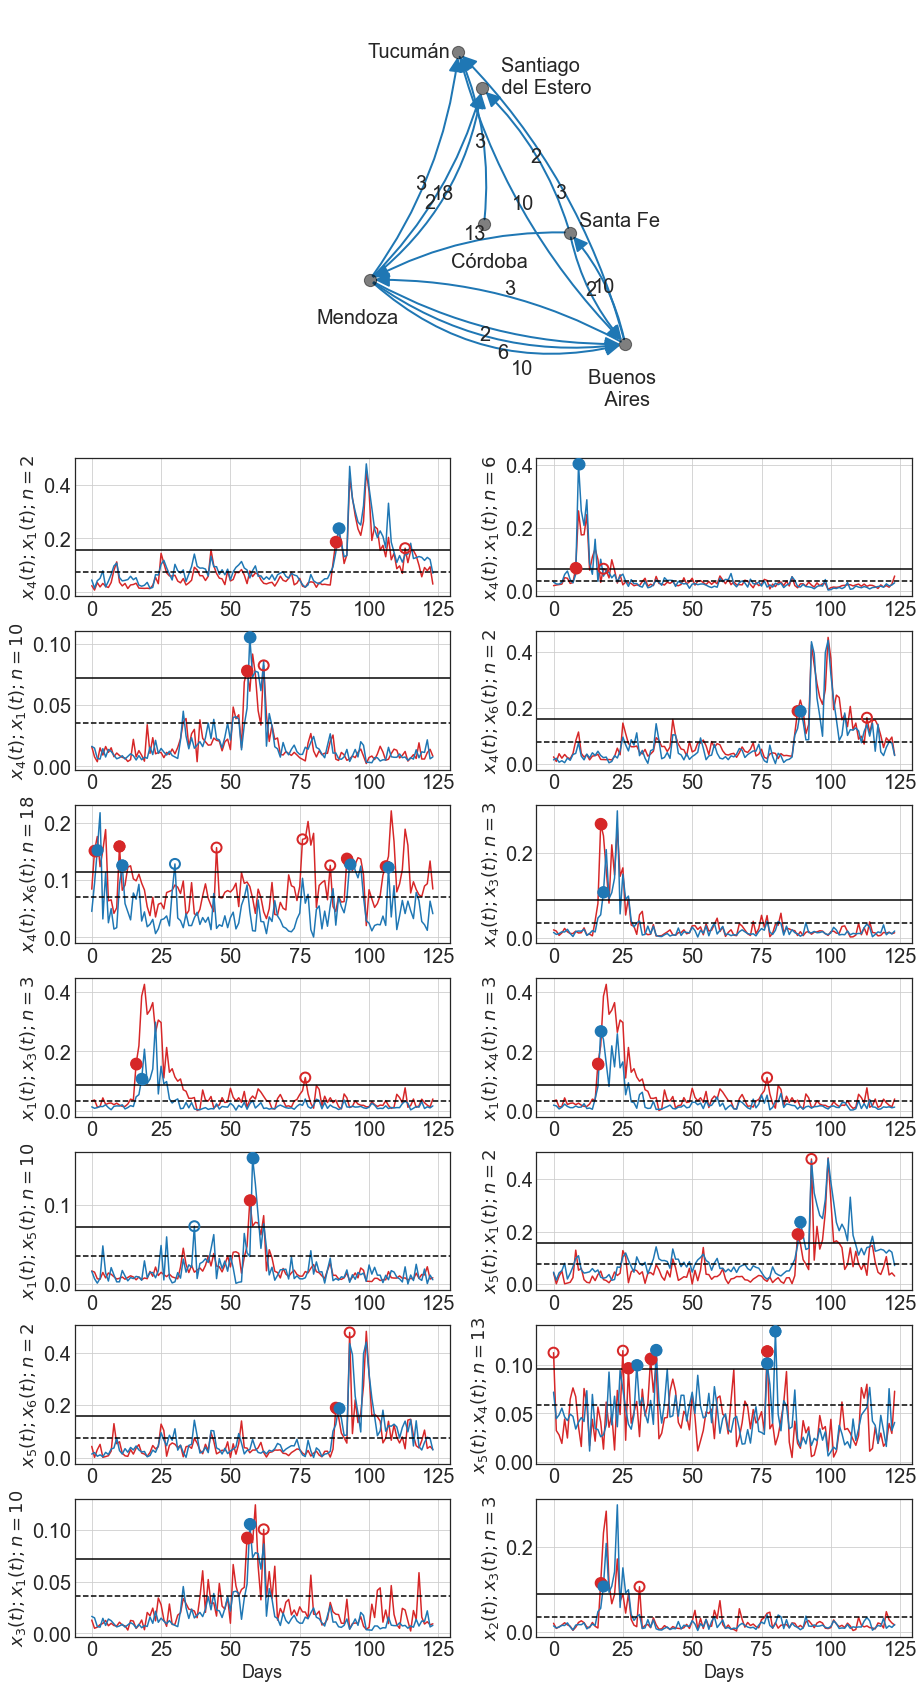

In [243]:
pos={0:(-58.45,-34.6),1:(-64.18,-31.41),2:(-65.22,-26.82),3:(-68.82,-32.89),4:(-60.7,-31.63),5:(-64.26,-27.79)}
labels=['Buenos \n Aires','Córdoba','Tucumán','Mendoza','Santa Fe','Santiago \n del Estero']
nodos_label2={i:m for i,m in enumerate(labels)}
new_pos_nodes2 = {}
for k,v in pos.items():
    x,y=v
    if labels[k]=='Santiago \n del Estero':
        x_shift,y_shift=2.5,0.3
        new_pos_nodes2[k]=(x + x_shift, y + y_shift) 
    elif labels[k]=='Santa Fe':
        x_shift,y_shift=2, 0.3
        new_pos_nodes2[k]=(x + x_shift, y + y_shift) 
    elif labels[k]=='Buenos \n Aires':
        x_shift,y_shift=0, -1.2
        new_pos_nodes2[k]=(x + x_shift, y + y_shift) 
    elif labels[k]=='Tucumán':
        x_shift,y_shift=-2, 0
        new_pos_nodes2[k]=(x + x_shift, y + y_shift) 
    elif labels[k]=='Córdoba':
        x_shift,y_shift=0.2, -1
        new_pos_nodes2[k]=(x + x_shift, y + y_shift) 
    elif labels[k]=='Mendoza':
        x_shift,y_shift=-0.5, -1
        new_pos_nodes2[k]=(x + x_shift, y + y_shift) 

fig = plt.figure(figsize=(15, 30))

nrows,ncols=8,4
gs = gridspec.GridSpec(nrows=nrows,ncols=ncols,height_ratios=[3,1,1,1,1,1,1,1])
        
met='QA'

dict2graf= {k:v[2] for k,v in redes_DI.items()}

axis=[]
for fila in range(nrows):
    for column in range(ncols):
        if (fila == 0) and (column == 0):
            ax_center=fig.add_subplot(gs[0,1:3])

            # Crear un multigrafo vacío
            multi_graph = nx.MultiDiGraph()

            # Iterar sobre las matrices de adyacencia y agregar los bordes al multigrafo
            for et,matrix in dict2graf.items():
                graph = nx.from_numpy_matrix(matrix, create_using=nx.MultiDiGraph)
                multi_graph.add_edges_from(graph.edges(), tema=et)

            multi_graph.remove_edges_from(nx.selfloop_edges(multi_graph))

            ax.set_facecolor('white')
            nx.draw_networkx_nodes(range(len(provincias2analyze)), pos=pos, ax=ax_center, node_color = 'k',node_size = 150, alpha = 0.5)


            for k,v,l,et in list(multi_graph.edges(keys=True,data=True)):
                et=et['tema']
                label = dict_titulos[et]
                radio=l+2
                
                linecolor='tab:blue'
                alpha=1
                zorder=1

                x0, y0 = pos[k]
                x1, y1 = pos[v]

                arr = mpatches.FancyArrowPatch((x0, y0),(x1, y1),
                                               arrowstyle="-|>", color=linecolor,linewidth=2,alpha=alpha,
                                                shrinkA=5, shrinkB=5,mutation_scale=30,
                                                patchA=None, patchB=None,zorder=zorder,
                                                connectionstyle="arc3,rad=rrr".replace('rrr',str(0.2*radio/3)))
                ax_center.add_patch(arr)

                xs=np.linspace(0,1,num=14)
                inx_mid=int(len(xs)/2)+radio-3

                ys=[func_spline((x0,y0),(x1,y1),x,rad=0.2*radio/3) for x in xs]
                equis=np.asarray(ys)[:,0]
                #dxs=equis[1]-equis[0]
                yies=np.asarray(ys)[:,1]

                ax_center.annotate("{}".format(label), (equis[inx_mid],yies[inx_mid]), xycoords='data', 
                               ha='center',va='center', fontsize=fontsize_small,zorder=5)


            ymin,ymax=ax_center.get_ylim()
            xmin,xmax=ax_center.get_xlim()

            scale_factor=0.03
            ax_center.set_xlim(xmin-abs(xmin*scale_factor),xmax+abs(xmax*scale_factor))
            ax_center.set_ylim(ymin-abs(ymin*scale_factor),ymax+abs(ymax*scale_factor))
            
            #ax_center.set_zorder(20)
            #nx.draw_networkx_labels(multi_graph, pos=new_pos_nodes2,ax=ax_center, labels=nodos_label2,
            #                    font_size=fontsize_small, font_color="k",alpha=1)    
            
            for key,value in new_pos_nodes2.items():
                x,y=value
                ax_center.annotate(nodos_label2[key], (x,y), xycoords='data', 
                                   ha='center',va='center', fontsize=fontsize_small,zorder=5)
            ax_center.axis('off')
            
        elif (fila == 0) and (column != 0):
            pass
        elif (fila > 0) and (column in [0,2]):
            axis.append(fig.add_subplot(gs[fila,column:column+2]))

    
for ax,sub in list(zip(axis,list(multi_graph.edges(keys=True,data=True)))):    
    k,v,l,et=sub
    int_top=et['tema']
    colp1='tab:red'
    colp2='tab:blue'
    label_top = dict_titulos[int_top]        
    j1=provincias2analyze[k]
    j2=provincias2analyze[v]

    dfsel=dfs[topics_names.index(int_top)]
    _,umbrales=matrices_topicos[int_top]
    th0,th1=umbrales

    y1=dfsel[j1].copy()
    y2=dfsel[j2].copy()

    x1=range(len(y1))
    p1,=ax.plot(y1,color=colp1,label=j1)
    p2,=ax.plot(y2,color=colp2,label=j2)

    ev_array1=ev.event_transform_cristina(y1,th1,th0)
    indev1=np.nonzero(ev_array1)
    noe_c1=indev1[0].shape[0]

    eventos1=dfsel[j1].to_numpy()[indev1]
    ax.scatter(indev1,eventos1,s=100,facecolors='none', edgecolors=colp1,linewidth=2,zorder=3)


    ev_array2=ev.event_transform_cristina(y2,th1,th0)
    indev2=np.nonzero(ev_array2)
    noe_c2=indev2[0].shape[0]

    eventos2=dfsel[j2].to_numpy()[indev2]
    ax.scatter(indev2,eventos2,s=100,facecolors='none', edgecolors=colp2,linewidth=2,zorder=3)


    indx_a,c_a=ev.func_c(ev_array1,ev_array2,lag=Lag)
    indx_b,c_b=ev.func_c(ev_array2,ev_array1,lag=Lag)

    eventos_totales=(noe_c1+noe_c2)

    if int_top == 'Diego_Luciani':
        if eventos_totales != 0:
            s= 2*(c_b + c_a)/eventos_totales
            a= 2*(c_b - c_a)/eventos_totales
        else:
            s=0
            a=0
        print(j1,j2,s,a)


    coincidencias_az=[]
    for ev_az in indev2[0]:
        for ev_r in indev1[0]:
            dif= ev_az - ev_r
            if 0<= dif <= Lag:
                #si appendeo ev_az veo los eventos azules sobre rojo
                #si appendeo ev_r veo los eventos en rojo que ven los azules
                coincidencias_az.append(ev_r)
            else:
                coincidencias_az.append('nan')
    coincidencias_az=np.asarray(coincidencias_az)
    coin_az=coincidencias_az[coincidencias_az.astype(str)  != 'nan']
    indx2paint_az=[int(x) for x in coin_az]

    evb=dfsel[j1].to_numpy()[indx2paint_az]
    ax.scatter(indx2paint_az,evb,s=100, color=colp1,linewidth=2,zorder=3)

    coincidencias_r=[]
    for ev_r in indev1[0]:
        for ev_az in indev2[0]:
            dif= ev_r - ev_az
            if 0<= dif <= Lag:
                coincidencias_r.append(ev_az)
            else:
                coincidencias_r.append('nan')

    coincidencias_r=np.asarray(coincidencias_r)
    coin_r=coincidencias_r[coincidencias_r.astype(str) != 'nan']
    indx2paint_r=[int(x) for x in coin_r]
    evb=dfsel[j2].to_numpy()[indx2paint_r]


    eva=dfsel[j2].to_numpy()[indx_a]
    ax.scatter(indx_a,eva,s=100, color=colp2,linewidth=2,zorder=3)


    ax.axhline(th1,c='k',lw=1.5)
    ax.axhline(th0,c='k',ls='--',lw=1.5)

    ax.grid(True)
    st1='x_{}(t)'.format(k+1)
    st2='x_{}(t)'.format(v+1)

    st=st1 + ' ; ' + st2 + ' ; n={}'.format(label_top)
    #ax.set_title('Topic number: {}'.format(label_top), fontsize=fontsize_small)
    ax.set_ylabel(r'${}$'.format(st),fontsize=fontsize_xsmall)
    #ax.set_xticklabels([])
    ax.tick_params(axis='y', which='major', labelsize=fontsize_small)
    ax.tick_params(axis='both', which='major', labelsize=fontsize_small)
    

axis[12].set_xlabel('Days',fontsize=fontsize_xsmall)
axis[13].set_xlabel('Days',fontsize=fontsize_xsmall)

plt.subplots_adjust(hspace=0.2,wspace=0.6)
plt.show()

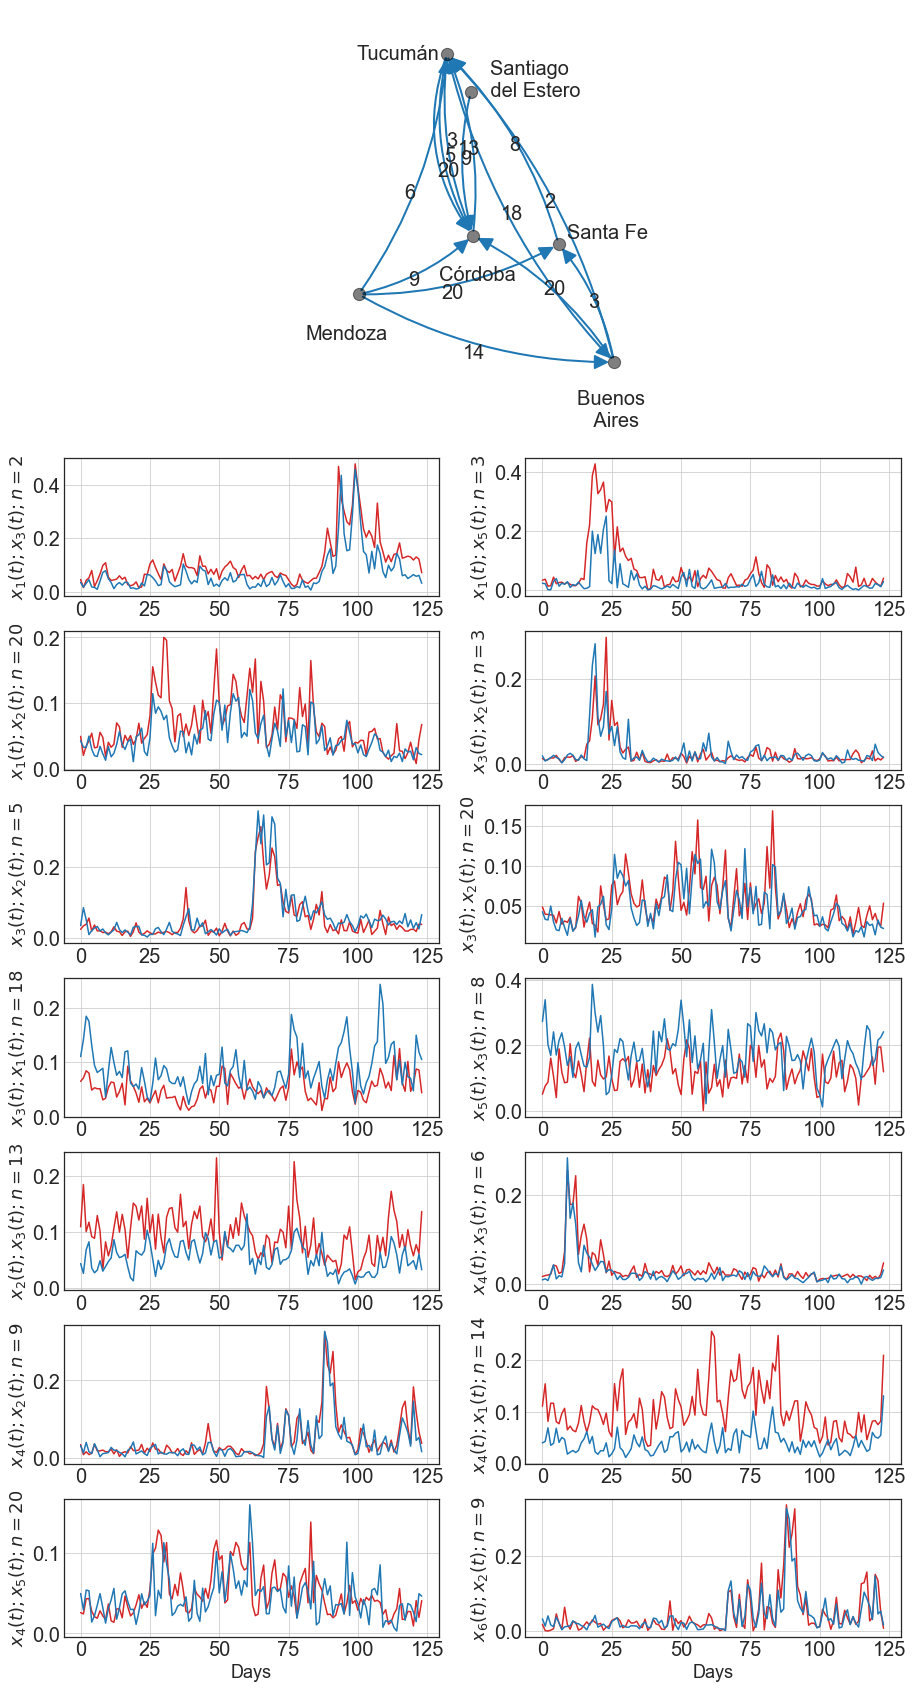

In [245]:
pos={0:(-58.45,-34.6),1:(-64.18,-31.41),2:(-65.22,-26.82),3:(-68.82,-32.89),4:(-60.7,-31.63),5:(-64.26,-27.79)}
labels=['Buenos \n Aires','Córdoba','Tucumán','Mendoza','Santa Fe','Santiago \n del Estero']
nodos_label2={i:m for i,m in enumerate(labels)}
new_pos_nodes2 = {}
for k,v in pos.items():
    x,y=v
    if labels[k]=='Santiago \n del Estero':
        x_shift,y_shift=2.5,0.3
        new_pos_nodes2[k]=(x + x_shift, y + y_shift) 
    elif labels[k]=='Santa Fe':
        x_shift,y_shift=2, 0.3
        new_pos_nodes2[k]=(x + x_shift, y + y_shift) 
    elif labels[k]=='Buenos \n Aires':
        x_shift,y_shift=0, -1.2
        new_pos_nodes2[k]=(x + x_shift, y + y_shift) 
    elif labels[k]=='Tucumán':
        x_shift,y_shift=-2, 0
        new_pos_nodes2[k]=(x + x_shift, y + y_shift) 
    elif labels[k]=='Córdoba':
        x_shift,y_shift=0.2, -1
        new_pos_nodes2[k]=(x + x_shift, y + y_shift) 
    elif labels[k]=='Mendoza':
        x_shift,y_shift=-0.5, -1
        new_pos_nodes2[k]=(x + x_shift, y + y_shift) 

fig = plt.figure(figsize=(15, 30))

nrows,ncols=8,4
gs = gridspec.GridSpec(nrows=nrows,ncols=ncols,height_ratios=[3,1,1,1,1,1,1,1])
        
met='TE' # 'GC', 'TE'

if met == 'GC':
    dict2graf= {k:v[1] for k,v in redes_DI.items()}
elif met =='TE':
    dict2graf= {k:v[0] for k,v in redes_DI.items()}

axis=[]
for fila in range(nrows):
    for column in range(ncols):
        if (fila == 0) and (column == 0):
            ax_center=fig.add_subplot(gs[0,1:3])

            # Crear un multigrafo vacío
            multi_graph = nx.MultiDiGraph()

            #matrices=np.asarray(list(dict_adys.values()))
            # Iterar sobre las matrices de adyacencia y agregar los bordes al multigrafo
            for et,matrix in dict2graf.items():
                graph = nx.from_numpy_matrix(matrix, create_using=nx.MultiDiGraph)
                multi_graph.add_edges_from(graph.edges(), tema=et)

            multi_graph.remove_edges_from(nx.selfloop_edges(multi_graph))

            ax.set_facecolor('white')
            nx.draw_networkx_nodes(range(len(provincias2analyze)), pos=pos, ax=ax_center, node_color = 'k',node_size = 150, alpha = 0.5)


            for k,v,l,et in list(multi_graph.edges(keys=True,data=True)):
                et=et['tema']
                label = dict_titulos[et]
                radio=l+2
                
                linecolor='tab:blue'
                alpha=1
                zorder=1

                x0, y0 = pos[k]
                x1, y1 = pos[v]

                arr = mpatches.FancyArrowPatch((x0, y0),(x1, y1),
                                               arrowstyle="-|>", color=linecolor,linewidth=2,alpha=alpha,
                                                shrinkA=5, shrinkB=5,mutation_scale=30,
                                                patchA=None, patchB=None,zorder=zorder,
                                                connectionstyle="arc3,rad=rrr".replace('rrr',str(0.2*radio/3)))
                ax_center.add_patch(arr)

                xs=np.linspace(0,1,num=14)
                inx_mid=int(len(xs)/2)+radio-3

                ys=[func_spline((x0,y0),(x1,y1),x,rad=0.2*radio/3) for x in xs]
                equis=np.asarray(ys)[:,0]
                yies=np.asarray(ys)[:,1]

                ax_center.annotate("{}".format(label), (equis[inx_mid],yies[inx_mid]), xycoords='data', 
                               ha='center',va='center', fontsize=fontsize_small,zorder=5)


            ymin,ymax=ax_center.get_ylim()
            xmin,xmax=ax_center.get_xlim()

            scale_factor=0.03
            ax_center.set_xlim(xmin-abs(xmin*scale_factor),xmax+abs(xmax*scale_factor))
            ax_center.set_ylim(ymin-abs(ymin*scale_factor),ymax+abs(ymax*scale_factor))
  
            
            for key,value in new_pos_nodes2.items():
                x,y=value
                ax_center.annotate(nodos_label2[key], (x,y), xycoords='data', 
                                   ha='center',va='center', fontsize=fontsize_small,zorder=5)
            ax_center.axis('off')
            
        elif (fila == 0) and (column != 0):
            pass
        elif (fila > 0) and (column in [0,2]):
            axis.append(fig.add_subplot(gs[fila,column:column+2]))

    
for ax,sub in list(zip(axis,list(multi_graph.edges(keys=True,data=True)))):
    k,v,l,et=sub
    int_top=et['tema']
    colp1='tab:red'
    colp2='tab:blue'
    label_top = dict_titulos[int_top]        
    j1=provincias2analyze[k]
    j2=provincias2analyze[v]

    dfsel=dfs[topics_names.index(int_top)]

    y1=dfsel[j1].copy()
    y2=dfsel[j2].copy()

    x1=range(len(y1))
    plot1,=ax.plot(y1,color=colp1,label=j1)
    plot2,=ax.plot(y2,color=colp2,label=j2)

    ax.grid(True)
    st1='x_{}(t)'.format(k+1)
    st2='x_{}(t)'.format(v+1)

    st=st1 + ' ; ' + st2 + ' ; n={}'.format(label_top)
    ax.set_ylabel(r'${}$'.format(st),fontsize=fontsize_xsmall)
    ax.tick_params(axis='y', which='major', labelsize=fontsize_small)
    ax.tick_params(axis='both', which='major', labelsize=fontsize_small)

axis[12].set_xlabel('Days',fontsize=fontsize_xsmall)
axis[13].set_xlabel('Days',fontsize=fontsize_xsmall)

plt.subplots_adjust(hspace=0.2,wspace=0.6)

plt.show()